## 导入模块

In [1]:
import argparse
import random
import faiss
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from deepctr.feature_column import build_input_features, input_from_feature_columns, SparseFeat, VarLenSparseFeat
from deepctr.layers.core import DNN, PredictionLayer
from deepctr.layers.utils import combined_dnn_input

import pandas as pd
import numpy as np

# 设置显示选项：不省略列、不省略行、不截断内容
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_colwidth', None)  # 显示每列完整内容
pd.set_option('display.expand_frame_repr', False)  # 不自动换行显示DataFrame

import matplotlib.pyplot as plt

Please check the latest version manually on https://pypi.org/project/deepctr/#history


## 工具函数

### 配置文件内容

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description="DSSM Recommendation System Parameters")

    parser.add_argument("--data_dir", type=str,
                        default=r"D:\software\pycharm_repository\StarMaker\MultiRecSys\data_files\dssm_data_2.csv",
                        help="原始输入数据路径")
    parser.add_argument("--data_final_dir", type=str,
                        default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_finash.csv", help="最终处理后的数据路径")

    parser.add_argument("--seq_len", type=int, default=15, help="用户历史序列的最大长度")
    parser.add_argument("--min_count", type=int, default=5, help="商品被点击的最小次数（过滤低频）")
    parser.add_argument("--negsample", type=int, default=3, help="负采样的数量")
    parser.add_argument("--embedding_dim", type=int, default=30, help="Embedding 向量维度")
    parser.add_argument("--batch_size", type=int, default=256, help="训练的批次大小")
    parser.add_argument("--epochs", type=int, default=20, help="训练轮数")
    parser.add_argument("--validation_split", type=float, default=0.2, help="验证集划分比例")
    parser.add_argument("--layer_embeding", type=int, default=32, help="模型中间层嵌入维度")
    parser.add_argument("--pred_topk", type=int, default=200, help="召回预测时选取的 Top-K 数量")
    parser.add_argument("--recall_topk", type=int, default=3, help="评估时的 Top-K 召回覆盖率")

    parser.add_argument("--save_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_u2i.txt",
                        help="主召回结果保存路径")
    parser.add_argument("--save_dir_new", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_new.txt",
                        help="新召回结果保存路径")
    parser.add_argument("--save_sdm_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/sdm_data_u2i.txt",
                        help="SDM 模型召回结果保存路径")
    parser.add_argument("--save_mind_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/mind_data_u2i.txt",
                        help="MIND 模型召回结果保存路径")
    parser.add_argument("--save_final_dir", type=str,
                        default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_final_u2i.txt", help="最终合并召回结果保存路径")

    parser.add_argument("--user_dnn_hidden_units", type=str, default="(64, 32)", help="用户塔的 DNN 层单元")
    parser.add_argument("--item_dnn_hidden_units", type=str, default="(64, 32)", help="物品塔的 DNN 层单元")
    
    # ✅ 关键：让 argparse 忽略 Jupyter 注入的无关参数
    # Jupyter 会自动向 argparse 传入 notebook 的内部参数（比如 -f kernel-xxx.json），而你没有设置接受这些参数，所以报错
    args, _ = parser.parse_known_args()
    return args

In [3]:
def recall_N(y_true, y_pred, N=50):
    return len(set(y_pred[:N]) & set(y_true)) * 1.0 / len(y_true)

In [4]:
def cosine_similarity(a, b):
    """
    计算两个向量之间的余弦相似度
    a, b: shape=(batch_size, embedding_dim)
    返回 shape=(batch_size, 1)
    """
    a = tf.nn.l2_normalize(a, axis=1)  # 对每个向量按行归一化
    b = tf.nn.l2_normalize(b, axis=1)
    return tf.reduce_sum(tf.multiply(a, b), axis=1, keepdims=True)

## 读取日志数据、用户画像数据、item画像数据

In [5]:
args = parse_args()
data_file = args.data_dir
SEQ_LEN = args.seq_len
min_count = args.min_count
negsample = args.negsample
embedding_dim = args.embedding_dim
batch_size = args.batch_size
epoch = args.epochs
validation_split = args.validation_split
user_dnn_hidden_units = eval(args.user_dnn_hidden_units)
item_dnn_hidden_units = eval(args.item_dnn_hidden_units)

In [6]:
args

Namespace(batch_size=256, data_dir='D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\dssm_data_2.csv', data_final_dir='/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_finash.csv', embedding_dim=30, epochs=20, item_dnn_hidden_units='(64, 32)', layer_embeding=32, min_count=5, negsample=3, pred_topk=200, recall_topk=3, save_dir='/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_u2i.txt', save_dir_new='/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_new.txt', save_final_dir='/data1/guifang.ji/DSSM_SongRecall/data/dssm_final_u2i.txt', save_mind_dir='/data1/guifang.ji/DSSM_SongRecall/data/mind_data_u2i.txt', save_sdm_dir='/data1/guifang.ji/DSSM_SongRecall/data/sdm_data_u2i.txt', seq_len=15, user_dnn_hidden_units='(64, 32)', validation_split=0.2)

In [7]:
data_file

'D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\dssm_data_2.csv'

In [8]:
user_dnn_hidden_units

(64, 32)

In [9]:
item_dnn_hidden_units

(64, 32)

###  定义各种字段

In [10]:
# publish 训练特征
data_cloums = ["user_id", "sm_id", "timestamp", "level", "user_lang", "platform", "country",
               "gender", "age", "song_lang_id", "artist_gender", "song_quality", "song_recording_count",
               "song_genres", "song_create_time", "artist_country_id", "region", "is_new"]

features = ["user_id", "sm_id", "level", "user_lang", "platform",
            "country", "gender", "artist_gender", "age", "is_new",
            "song_quality", "song_recording_count", "song_genres"]

num_header = ["level", "gender", "age", "artist_gender", "is_new", "song_quality", "song_recording_count"]
string_header = ["user_id", "sm_id", "user_lang", "platform", "country", "song_genres"]
time_header = ["timestamp"]
user_fearther = ["user_id", "gender", "age", "level", "user_lang", "country", "platform", "is_new"]
item_fearther = ["sm_id", "artist_gender", "song_quality", "song_recording_count",
                 "song_genres"]  # "sm_language" 90% 为空，去掉
user_fearther_noid = ["gender", "age", "level", "user_lang", "country", "platform", "is_new"]
item_fearther_noid = ["artist_gender", "song_quality", "song_recording_count", "song_genres"]

# 录制训练特征
final_col = ["user_id", "sm_id", "timestamp", "level", "user_lang", "platform", "country",
             "gender", "age", "song_lang_id", "artist_gender", "song_quality", "song_recording_count",
             "song_genres", "song_create_time", "artist_country_id"]

In [11]:
user_fearther

['user_id',
 'gender',
 'age',
 'level',
 'user_lang',
 'country',
 'platform',
 'is_new']

In [12]:
item_fearther

['sm_id',
 'artist_gender',
 'song_quality',
 'song_recording_count',
 'song_genres']

### 读取日志数据并进行异常值处理

In [13]:
num_header

['level',
 'gender',
 'age',
 'artist_gender',
 'is_new',
 'song_quality',
 'song_recording_count']

In [14]:
string_header

['user_id', 'sm_id', 'user_lang', 'platform', 'country', 'song_genres']

In [15]:
time_header

['timestamp']

In [16]:
data = pd.read_csv(data_file, names=data_cloums, sep=',').head(2000)

for header in num_header:
    temp = data[header].fillna(-1)
    data[header] = temp
for header in string_header:
    temp = data[header].fillna("unknow")
    data[header] = temp
for header in time_header:
    temp = data[header].fillna(data[header].min())
    data[header] = temp

In [17]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,60456,611720463661,1672671210,5,hi,android,IN,1,0,11,1,1000.0,8989,unknow,1584604060,6,IN,0
1,60456,611024198908,1672691614,1,pt,android,BR,0,0,27,4,1000.0,42536,unknow,1634263591,215,BR,1
2,60456,611020836603,1672650725,3,hi,android,IN,2,4,11,1,1000.0,5194,unknow,1591585397,6,IN,0
3,60456,611024677061,1672697682,5,en,android,SA,2,0,2,2,1000.0,61038,unknow,1641524422,3,ME,0
4,60456,611718910963,1672701264,4,id,android,ID,2,5,23,1,1000.0,14252,Electronic,1511923985,79,ID,0
5,8426356,611021225275,1672671401,1,bn,android,BD,0,0,31,1,1000.0,3145,unknow,1592556657,91,BD,1
6,8426356,611755071229,1672660062,5,en,android,PH,2,0,2,2,1000.0,145452,unknow,1487232401,4,PH,0
7,8426356,611715621284,1672640270,3,tl,android,PH,1,0,2,1,1000.0,47748,Jazz,1492149188,2,PH,0
8,8426356,611720547780,1672661630,4,hi,android,IN,2,4,11,1,1000.0,3353,unknow,1587988984,6,IN,0
9,8426356,611719222892,1672654799,5,es,android,VE,1,0,25,1,1000.0,1285,Latin,1516679701,104,CO,0


### 日志数据离散特征与连续特征进行处理

In [18]:
feature_max_idx = {}
encoder = []
for feature in features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature]) + 1  # 特征预处理
    feature_max_idx[feature] = data[feature].max() + 1  # 处理后特征的最大值，用来记录特征的数量
    encoder.append(lbe)

In [19]:
encoder

[LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder()]

In [20]:
feature_max_idx

{'user_id': 197,
 'sm_id': 124,
 'level': 7,
 'user_lang': 23,
 'platform': 2,
 'country': 34,
 'gender': 5,
 'artist_gender': 6,
 'age': 7,
 'is_new': 3,
 'song_quality': 2,
 'song_recording_count': 98,
 'song_genres': 9}

In [21]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,11,97,1672671210,5,7,1,14,2,1,11,2,1,49,8,1584604060,6,IN,1
1,11,59,1672691614,1,15,1,5,1,1,27,5,1,81,8,1634263591,215,BR,2
2,11,44,1672650725,3,7,1,14,3,5,11,2,1,37,8,1591585397,6,IN,1
3,11,63,1672697682,5,4,1,27,3,1,2,3,1,88,8,1641524422,3,ME,1
4,11,90,1672701264,4,8,1,12,3,6,23,2,1,61,1,1511923985,79,ID,1
5,175,45,1672671401,1,2,1,3,1,1,31,2,1,24,8,1592556657,91,BD,2
6,175,120,1672660062,5,4,1,24,3,1,2,3,1,94,8,1487232401,4,PH,1
7,175,82,1672640270,3,19,1,24,2,1,2,2,1,85,4,1492149188,2,PH,1
8,175,98,1672661630,4,7,1,14,3,5,11,2,1,27,8,1587988984,6,IN,1
9,175,91,1672654799,5,5,1,32,2,1,25,2,1,6,5,1516679701,104,CO,1


### 构建user_profile画像数据-user_id是主键

In [22]:
user_fearther

['user_id',
 'gender',
 'age',
 'level',
 'user_lang',
 'country',
 'platform',
 'is_new']

In [23]:
user_profile = data[user_fearther].drop_duplicates('user_id')  # 用户特征，drop_duplicates 去重

In [24]:
user_profile

,user_id,gender,age,level,user_lang,country,platform,is_new
0,11,2,1,5,7,14,1,1
5,175,1,1,1,2,3,1,2
10,37,3,1,6,4,24,1,1
11,186,3,6,1,5,6,1,1
12,36,2,1,2,4,27,1,1
13,148,2,6,3,4,11,1,1
14,159,2,1,4,2,3,1,1
15,182,2,3,1,2,3,1,1
16,74,3,6,4,4,5,1,1
17,172,3,1,5,8,12,1,1


In [25]:
user_profile.set_index("user_id", inplace=True)  # 将user_id列转为索引，inplace表示在原数据上修改

In [26]:
user_profile.head()

,gender,age,level,user_lang,country,platform,is_new
user_id,,,,,,,
11,2,1,5,7,14,1,1
175,1,1,1,2,3,1,2
37,3,1,6,4,24,1,1
186,3,6,1,5,6,1,1
36,2,1,2,4,27,1,1


### 构建item_profile画像数据-item_id是主键

In [27]:
item_fearther

['sm_id',
 'artist_gender',
 'song_quality',
 'song_recording_count',
 'song_genres']

In [28]:
item_profile = data[item_fearther].drop_duplicates('sm_id')  # 物品特征，去重

In [29]:
item_profile

,sm_id,artist_gender,song_quality,song_recording_count,song_genres
0,97,2,1,49,8
1,59,5,1,81,8
2,44,2,1,37,8
3,63,3,1,88,8
4,90,2,1,61,1
5,45,2,1,24,8
6,120,3,1,94,8
7,82,2,1,85,4
8,98,2,1,27,8
9,91,2,1,6,5


In [30]:
item_profile.set_index("sm_id", inplace=True)

In [31]:
item_profile.head()

,artist_gender,song_quality,song_recording_count,song_genres
sm_id,,,,
97,2,1,49,8
59,5,1,81,8
44,2,1,37,8
63,3,1,88,8
90,2,1,61,1


### 获取所有的items

In [32]:
data[["sm_id"]]

,sm_id
0,97
1,59
2,44
3,63
4,90
5,45
6,120
7,82
8,98
9,91


In [33]:
item_ids = data[["sm_id"]].drop_duplicates('sm_id')

In [34]:
item_ids

,sm_id
0,97
1,59
2,44
3,63
4,90
5,45
6,120
7,82
8,98
9,91


##  根据日志数据进行正负样本采样

### 正负样本的构造思路

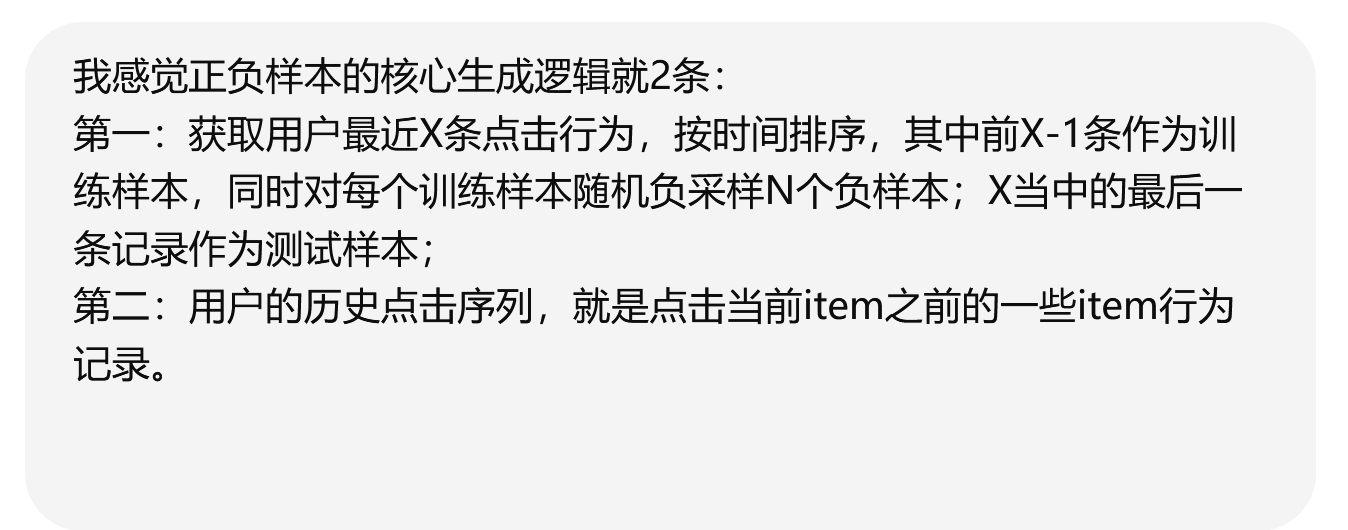

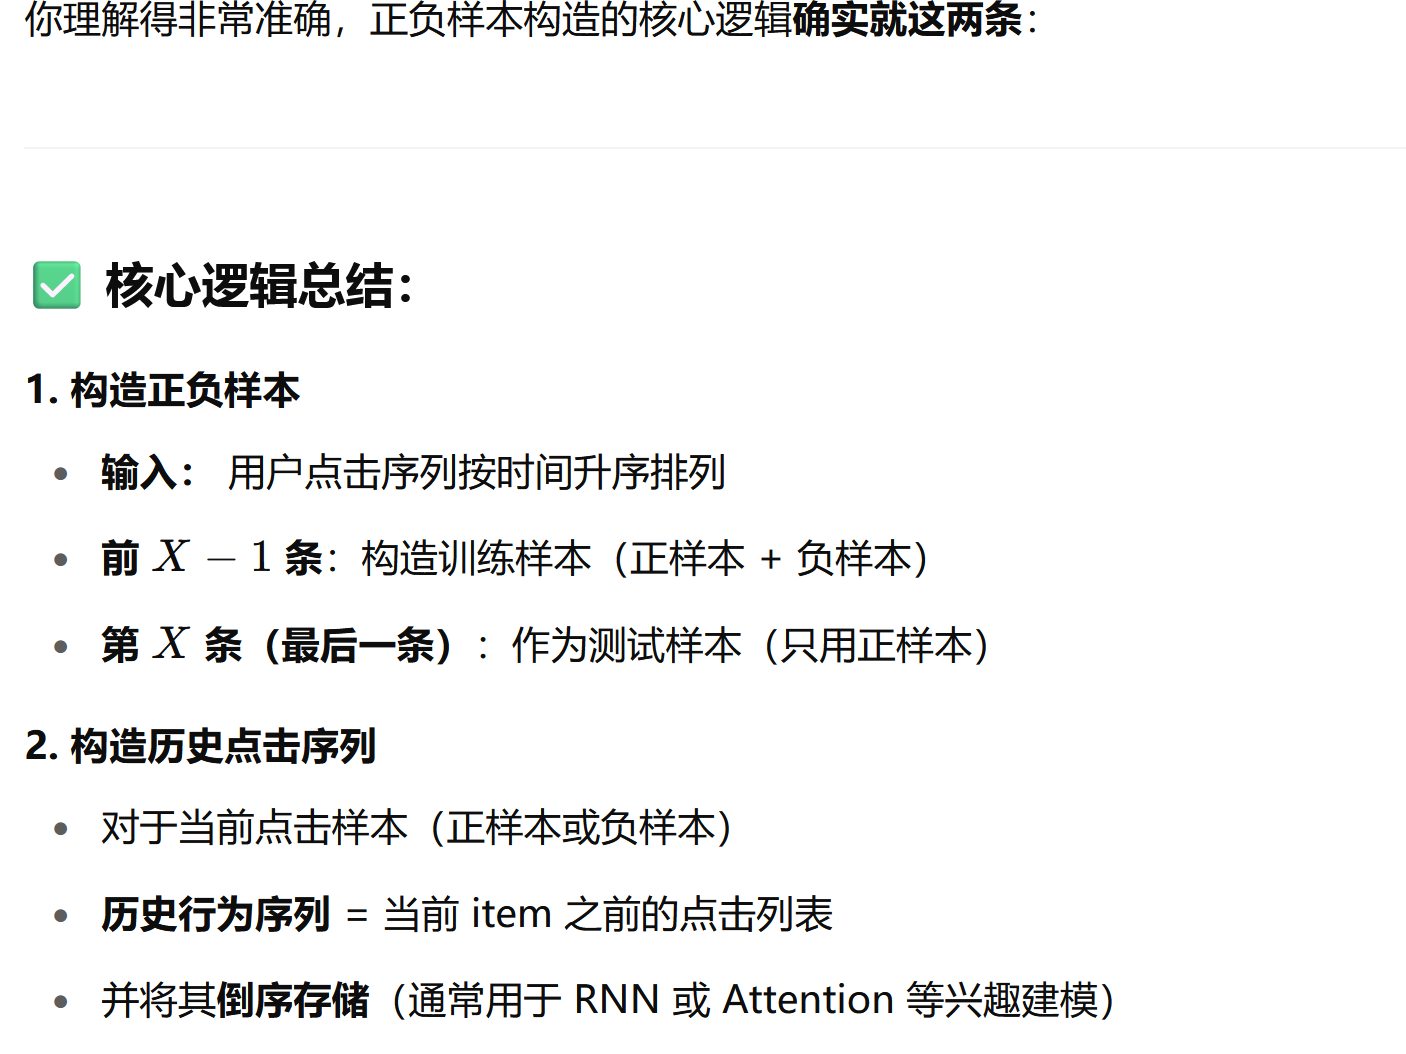

###  正负样本生成逻辑-python版本

In [35]:
def gen_data_set(data, min_count, negsample=0):
    data.sort_values("timestamp", inplace=True)
    item_ids = data[['sm_id']]
    # 统计sm_id 出现的次数, 转为dataframe
    item_ids = item_ids['sm_id'].value_counts().rename_axis('sm_id').reset_index(name='num')
    print(item_ids)
    item_ids = item_ids.loc[item_ids['num'] > min_count]
    print("-----------min_count-----------")
    print(min_count)

    # 最终，这一行得到的是：点击量比“平均热度阈值”还要高的物品行，即“热门物品”。
    # hot_ids = item_ids.loc[item_ids['num'] > int(item_ids["num"].sum() / (int(item_ids.shape[0] * 0.1)))]
    # hot_ids = set(hot_ids['sm_id'].unique())

    hot_ids = []

    item_nums = item_ids['num'].to_list()  # .div(item_ids['num'].sum())
    item_ids = item_ids['sm_id'].unique()

    train_set = []
    test_set = []
    count = 0
    user_items = {}
    print(data.groupby('user_id'))
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        # print(reviewerID, hist)
        pos_list = hist['sm_id'].tolist()  # 用户浏览过的item_id
        pos_list = pos_list[:min(100, len(pos_list))]
        user_items[reviewerID] = pos_list
        neg_list = set()
        if negsample > 0:  # 全局负采样
            candidate_set = list(set(item_ids) - set(pos_list))
            neg_list = np.random.choice(candidate_set, size=len(pos_list) * negsample, replace=True)

        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            if i != len(pos_list) - 1:
                # 用户ID + 浏览记录倒排 + 当前itemID + 正负样本label（1，0） + 浏览记录的长度 + item评分（正样本有，负样本没有）
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1]), 1))
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i * negsample + negi], 0, len(hist[::-1])))
            else:
                test_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1]), 1))
        count += 1
    
    # 打散（我这里为了方便看数据临时注释掉了）
    # random.shuffle(train_set)
    # random.shuffle(test_set)

    return train_set, test_set, user_items, hot_ids

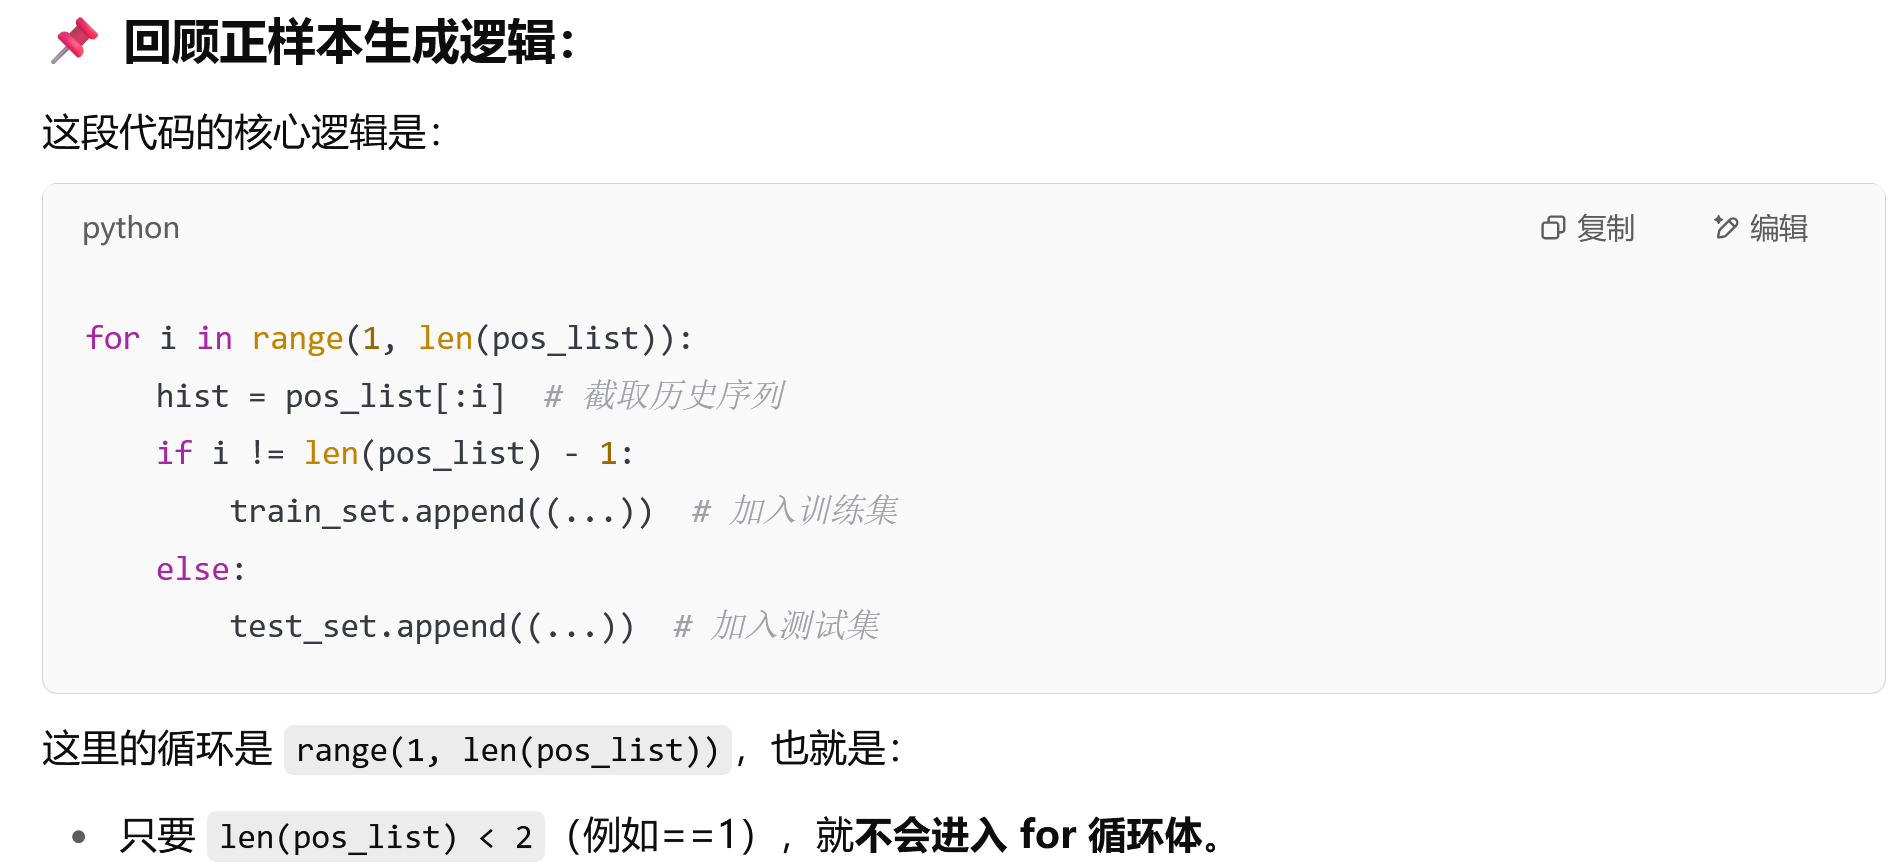

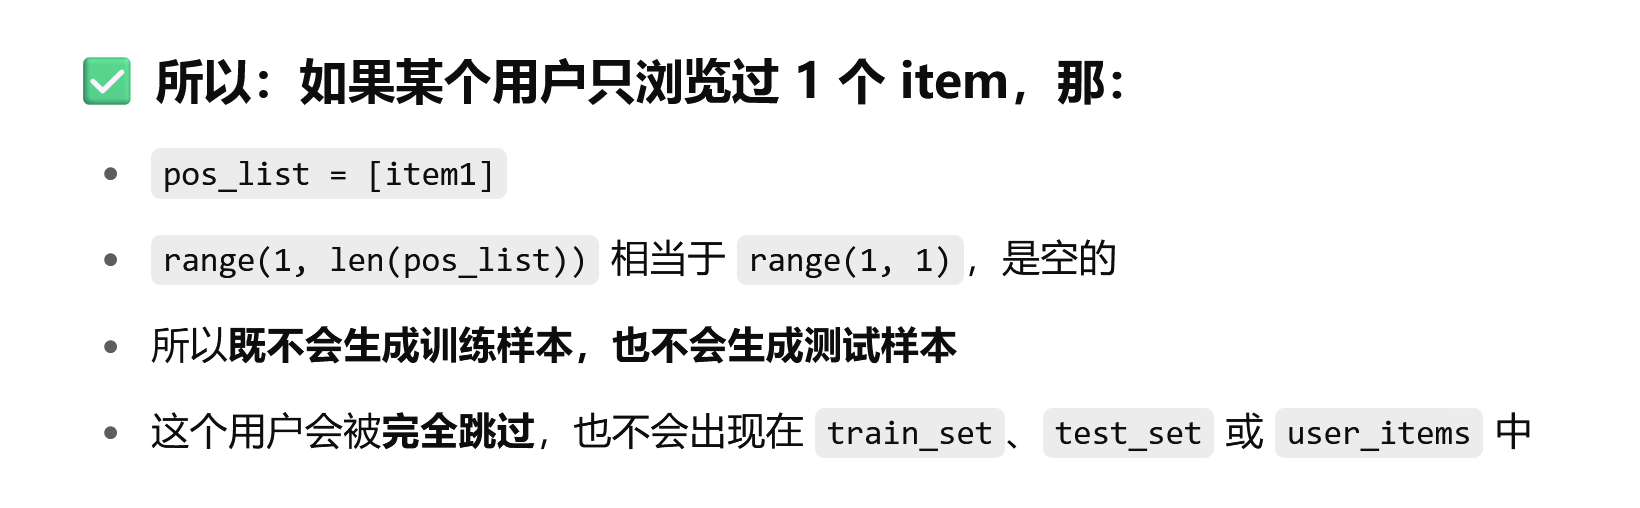

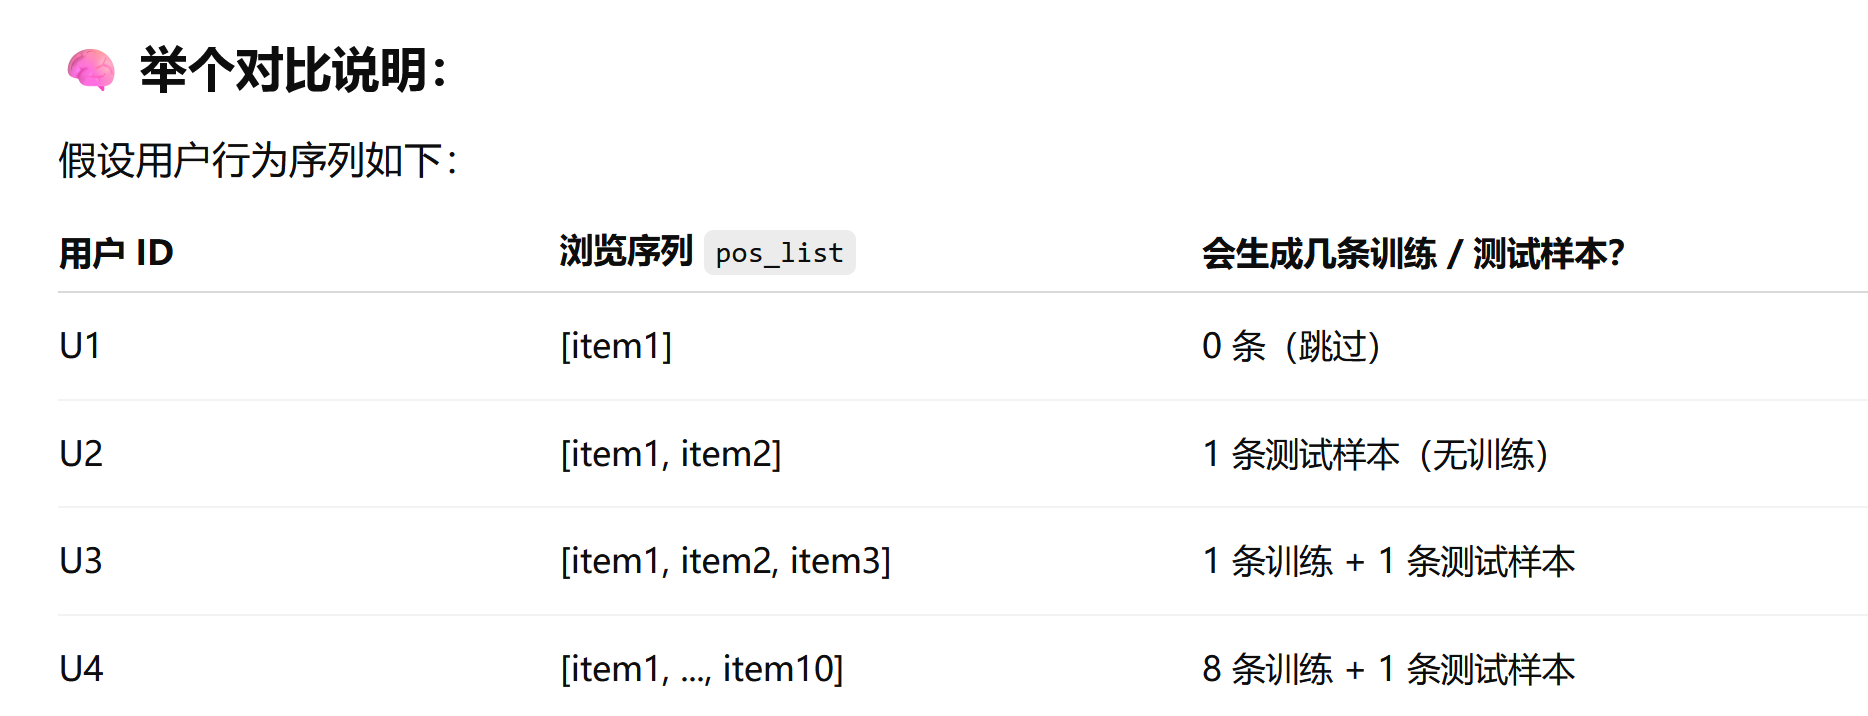

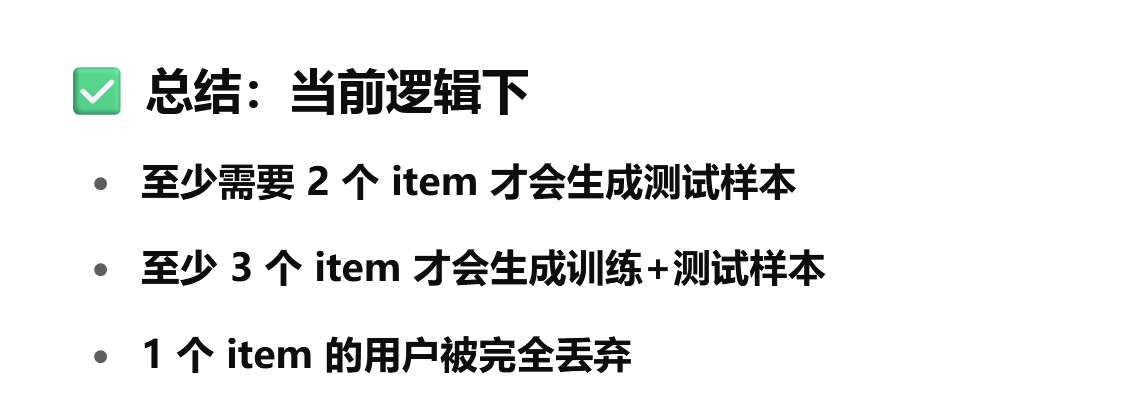

In [36]:
train_set, test_set, history_items, hot_ids = gen_data_set(data, min_count, negsample)  # 获取训练集和测试集，训练集和测试集采样方法可修改

     sm_id  num
0       44    9
1      113    8
2       59    8
3       45    6
4       63    5
5      101    4
6       11    4
7       43    4
8       99    4
9       48    4
10     109    4
11      34    4
12      90    3
13      32    3
14       7    3
15      84    3
16      98    3
17     106    3
18      72    3
19     103    3
20      85    2
21      27    2
22      39    2
23      87    2
24      97    2
25      61    2
26      82    2
27      49    2
28      26    2
29      18    2
30      38    2
31      91    2
32      30    2
33     108    2
34      47    2
35     120    2
36      17    2
37     107    2
38      80    2
39      93    2
40       6    2
41     105    2
42      77    2
43      66    2
44      60    1
45      53    1
46      35    1
47      25    1
48      54    1
49     122    1
50      73    1
51       4    1
52      95    1
53      36    1
54      81    1
55       5    1
56     102    1
57      10    1
58     114    1
59      52    1
60     116    1
61      

100%|██████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 6507.12it/s]


In [37]:
train_set  # 负采样的数量是三个

[(11, [44], 97, 1, 1, 1),
 (11, [44], 45, 0, 1),
 (11, [44], 45, 0, 1),
 (11, [44], 45, 0, 1),
 (11, [97, 44], 97, 1, 2, 1),
 (11, [97, 44], 45, 0, 2),
 (11, [97, 44], 113, 0, 2),
 (11, [97, 44], 45, 0, 2),
 (11, [97, 97, 44], 59, 1, 3, 1),
 (11, [97, 97, 44], 113, 0, 3),
 (11, [97, 97, 44], 45, 0, 3),
 (11, [97, 97, 44], 113, 0, 3),
 (11, [59, 97, 97, 44], 63, 1, 4, 1),
 (11, [59, 97, 97, 44], 113, 0, 4),
 (11, [59, 97, 97, 44], 45, 0, 4),
 (11, [59, 97, 97, 44], 113, 0, 4),
 (175, [82], 91, 1, 1, 1),
 (175, [82], 113, 0, 1),
 (175, [82], 59, 0, 1),
 (175, [82], 44, 0, 1),
 (175, [91, 82], 120, 1, 2, 1),
 (175, [91, 82], 44, 0, 2),
 (175, [91, 82], 59, 0, 2),
 (175, [91, 82], 59, 0, 2),
 (175, [120, 91, 82], 98, 1, 3, 1),
 (175, [120, 91, 82], 44, 0, 3),
 (175, [120, 91, 82], 44, 0, 3),
 (175, [120, 91, 82], 44, 0, 3),
 (175, [98, 120, 91, 82], 45, 1, 4, 1),
 (175, [98, 120, 91, 82], 59, 0, 4),
 (175, [98, 120, 91, 82], 59, 0, 4),
 (175, [98, 120, 91, 82], 59, 0, 4)]

In [38]:
test_set

[(11, [63, 59, 97, 97, 44], 90, 1, 5, 1),
 (36, [85], 85, 1, 1, 1),
 (37, [72], 72, 1, 1, 1),
 (74, [103], 103, 1, 1, 1),
 (148, [18], 18, 1, 1, 1),
 (159, [30], 30, 1, 1, 1),
 (165, [48], 48, 1, 1, 1),
 (172, [66], 66, 1, 1, 1),
 (175, [45, 98, 120, 91, 82], 45, 1, 5, 1),
 (182, [26], 26, 1, 1, 1),
 (186, [61], 61, 1, 1, 1)]

In [39]:
history_items

{1: [120],
 2: [106],
 3: [99],
 4: [84],
 5: [122],
 6: [123],
 7: [80],
 8: [117],
 9: [72],
 10: [101],
 11: [44, 97, 97, 59, 63, 90],
 12: [121],
 13: [116],
 14: [109],
 15: [101],
 16: [118],
 17: [119],
 18: [83],
 19: [102],
 20: [107],
 21: [106],
 22: [84],
 23: [113],
 24: [108],
 25: [99],
 26: [105],
 27: [87],
 28: [103],
 29: [75],
 30: [93],
 31: [91],
 32: [108],
 33: [74],
 34: [76],
 35: [44],
 36: [85, 85],
 37: [72, 72],
 38: [113],
 39: [86],
 40: [71],
 41: [90],
 42: [54],
 43: [98],
 44: [109],
 45: [89],
 46: [112],
 47: [115],
 48: [100],
 49: [43],
 50: [51],
 51: [88],
 52: [114],
 53: [93],
 54: [105],
 55: [21],
 56: [107],
 57: [34],
 58: [104],
 59: [106],
 60: [113],
 61: [96],
 62: [101],
 63: [63],
 64: [79],
 65: [109],
 66: [113],
 67: [78],
 68: [113],
 69: [95],
 70: [82],
 71: [2],
 72: [77],
 73: [113],
 74: [103, 103],
 75: [73],
 76: [110],
 77: [98],
 78: [99],
 79: [113],
 80: [70],
 81: [92],
 82: [101],
 83: [87],
 84: [80],
 85: [113],
 

In [40]:
data.sort_values("timestamp", inplace=True)
data[data["user_id"] == 11]

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
2,11,44,1672650725,3,7,1,14,3,5,11,2,1,37,8,1591585397,6,IN,1
0,11,97,1672671210,5,7,1,14,2,1,11,2,1,49,8,1584604060,6,IN,1
19,11,97,1672671210,5,7,1,14,2,1,11,2,1,49,8,1584604060,6,IN,1
1,11,59,1672691614,1,15,1,5,1,1,27,5,1,81,8,1634263591,215,BR,2
3,11,63,1672697682,5,4,1,27,3,1,2,3,1,88,8,1641524422,3,ME,1
4,11,90,1672701264,4,8,1,12,3,6,23,2,1,61,1,1511923985,79,ID,1


In [41]:
history_items[11]  # 按照时间升序看某个user_id的日志记录 (11, [63, 59, 97, 97, 44], 90, 1, 5, 1),

[44, 97, 97, 59, 63, 90]

In [42]:
hot_ids  # 这个感觉没有什么用。。

[]

### 正负样本生成逻辑-HiveSQL版本

In [43]:
# gen_data_set 函数中正负样本的构造逻辑，完全可以用 HiveSQL 实现，尤其如果你是在处理大规模日志数据，使用 HiveSQL 会更高效且易于分布式并行

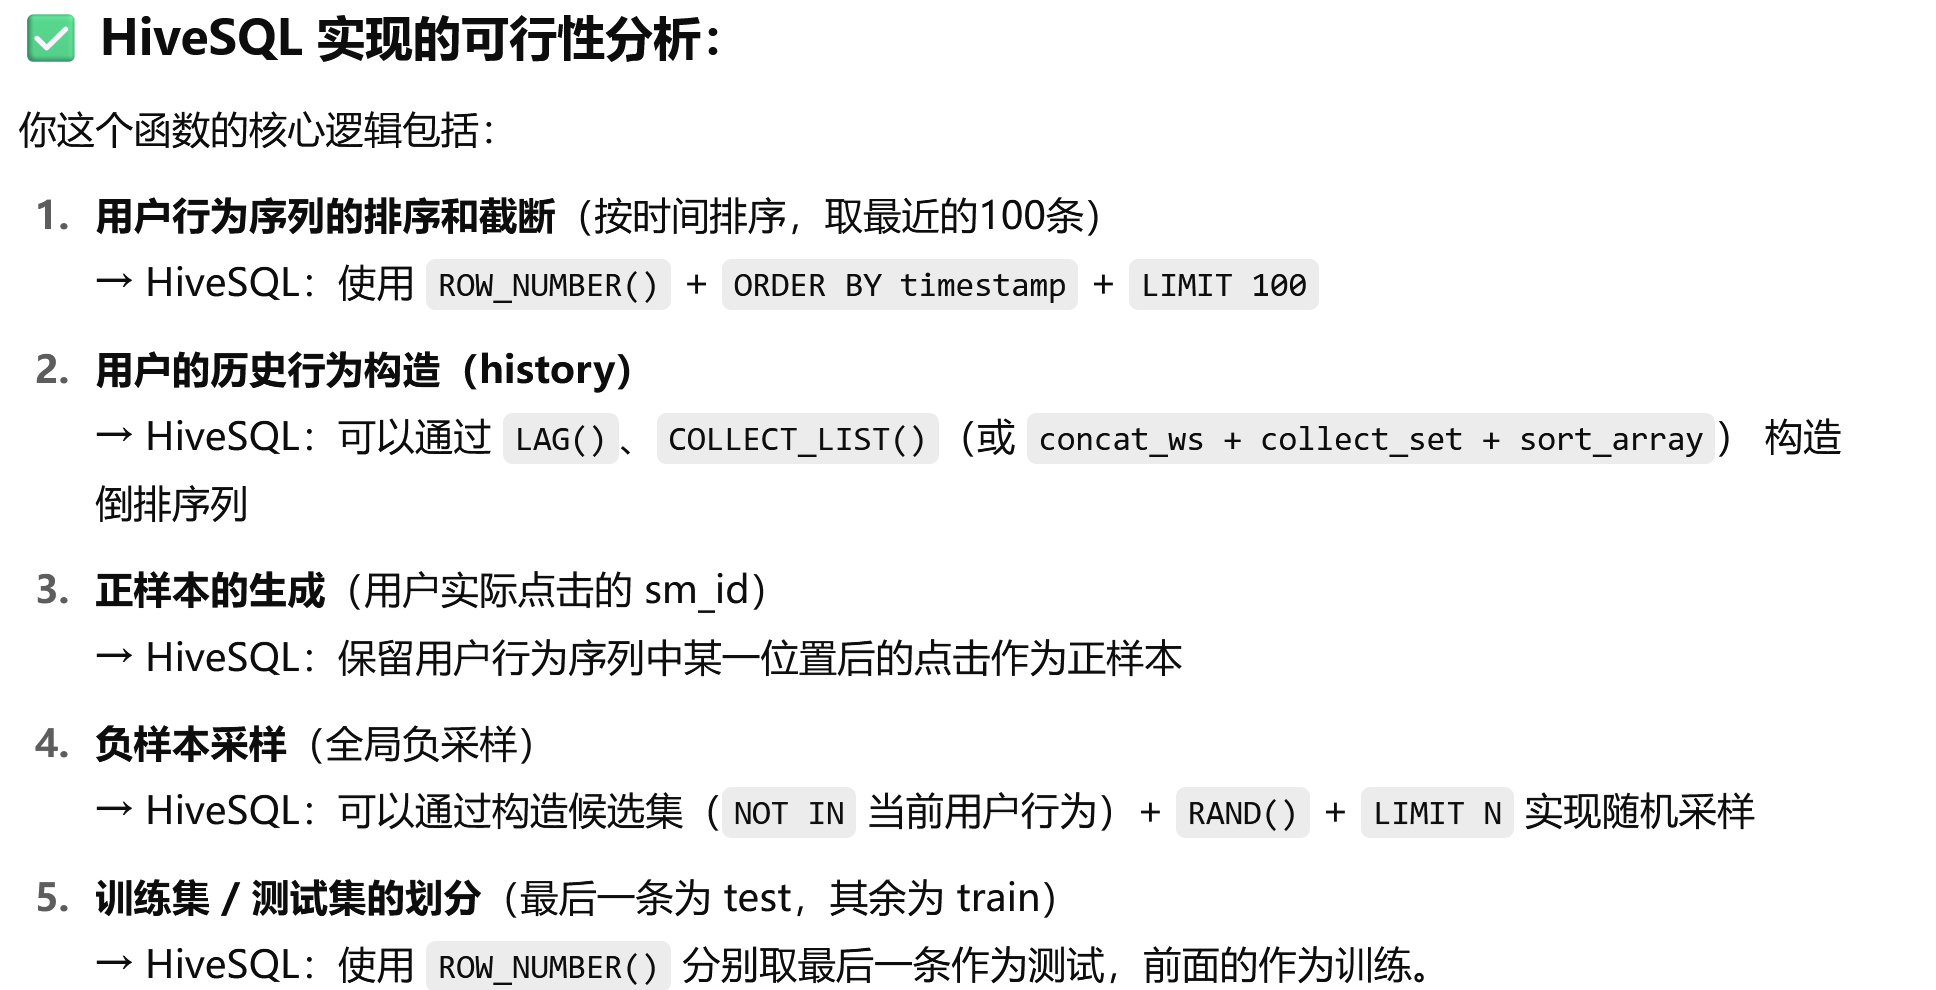

In [44]:
# -- 1. 先获取用户最近100条点击行为，按时间排序
# WITH user_actions AS (
#     SELECT
#         user_id,
#         sm_id,
#         timestamp,
#         ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) as rn
#     FROM raw_table
# ),
# user_top100 AS (
#     SELECT * FROM user_actions WHERE rn <= 100
# ),

# -- 2. 正样本：从第2条到倒数第2条为训练，最后一条为测试
# positive_samples AS (
#     SELECT
#         user_id,
#         sm_id AS target_item,
#         'positive' AS label,
#         timestamp,
#         rn
#     FROM user_top100
# ),

# -- 3. 负样本构造：每个用户抽取 K 个不在历史记录中的 sm_id
# candidate_items AS (
#     SELECT DISTINCT sm_id FROM raw_table
# ),
# user_neg_samples AS (
#     SELECT
#         a.user_id,
#         b.sm_id AS target_item,
#         'negative' AS label
#     FROM (SELECT DISTINCT user_id FROM user_top100) a
#     JOIN candidate_items b
#         ON b.sm_id NOT IN (SELECT sm_id FROM user_top100 WHERE user_id = a.user_id)
#     DISTRIBUTE BY a.user_id SORT BY RAND()
#     LIMIT N  -- 控制负采样数量
# )

# -- 4. 最终正负样本集合拼接
# SELECT * FROM positive_samples
# UNION ALL
# SELECT * FROM user_neg_samples;

In [45]:
# 你还可以进一步用 COLLECT_LIST() 聚合出用户的历史点击序列，在训练样本中带上 history 特征。

### 正负样本的核心字段-5个

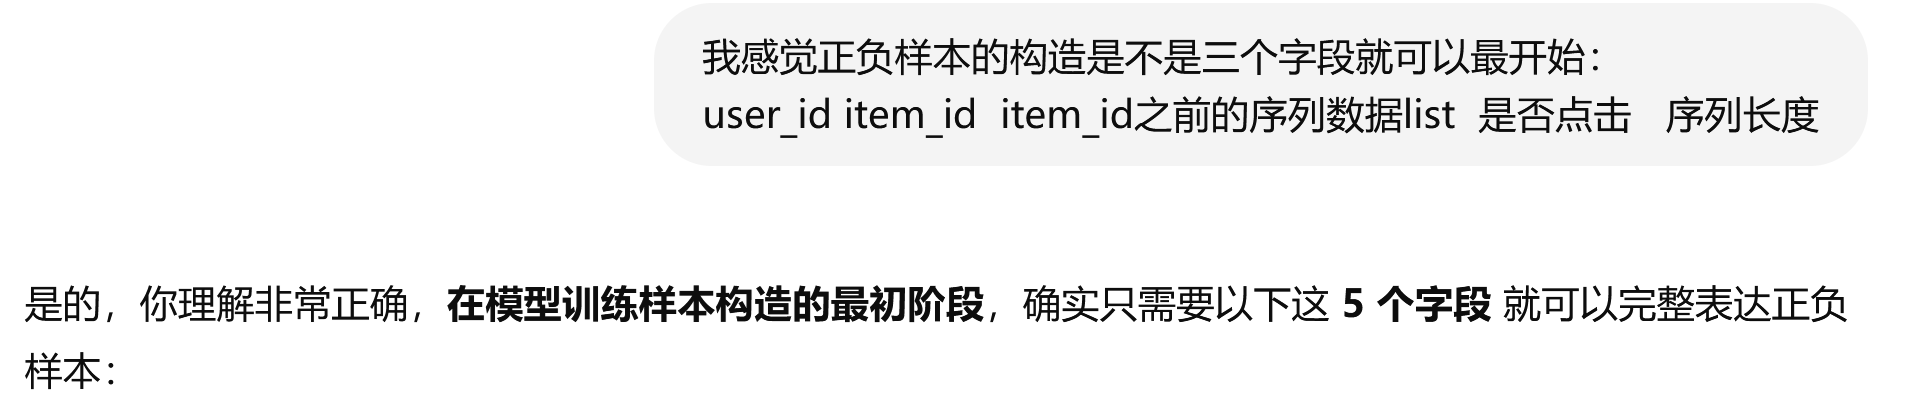

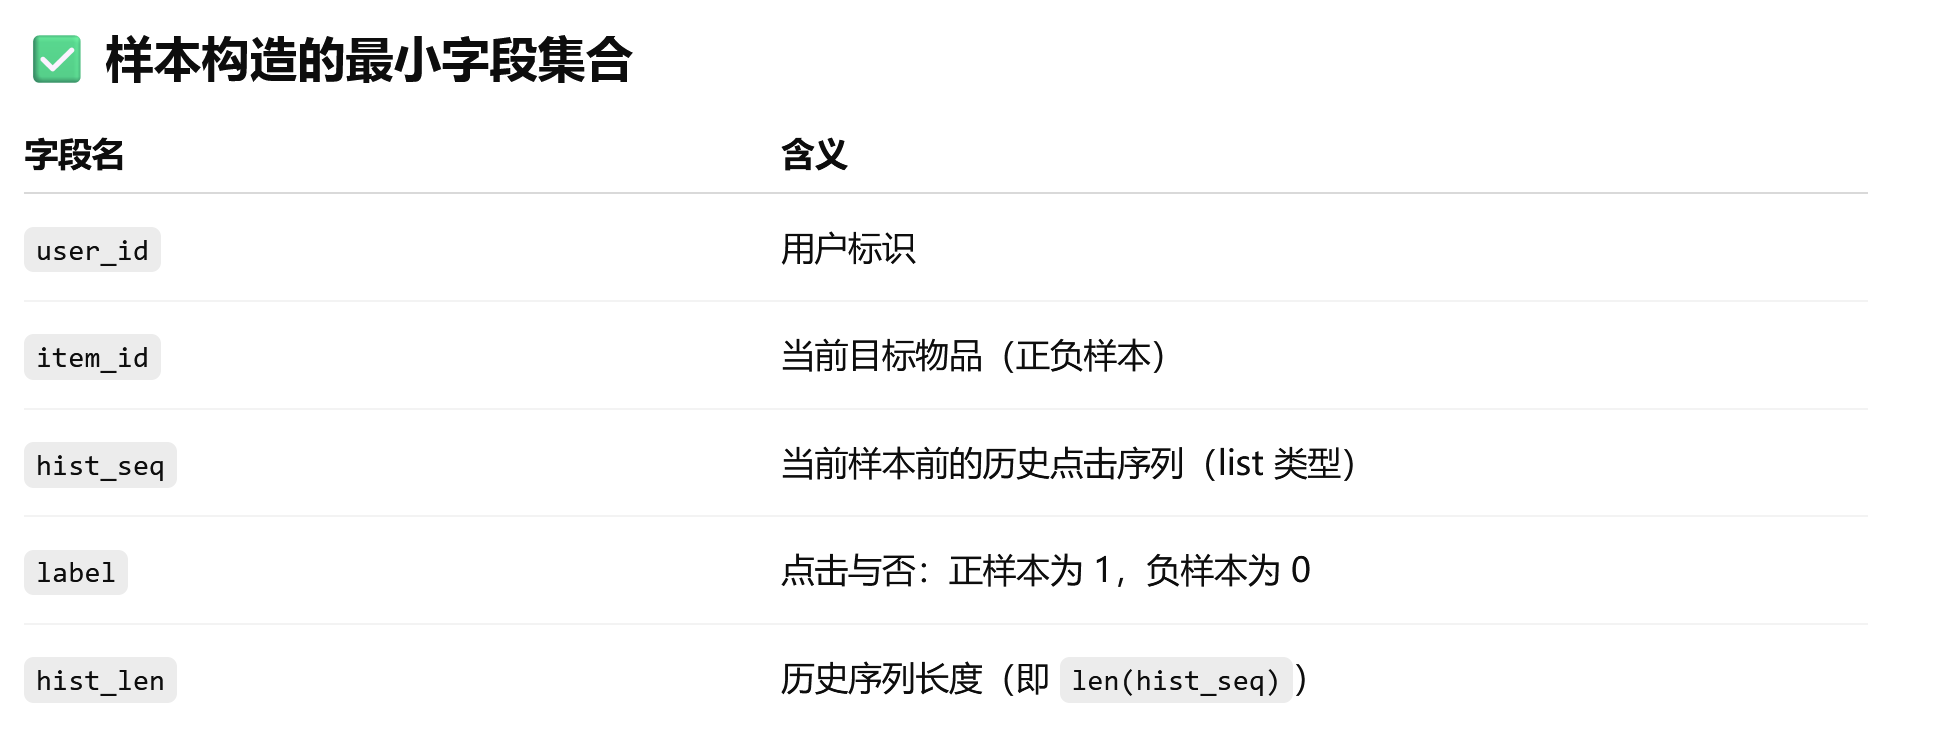

In [46]:
# 示例数据如下：user_id 、序列list、item_id、是否点击、序列长度，下面是按照1:3的比例生成的
# 注意:下面的例子当中对于正样本最后还多了一个1，感觉没什么用

In [47]:
# (175, [82], 91, 1, 1, 1),     
# (175, [82], 59, 0, 1),
# (175, [82], 113, 0, 1),
# (175, [82], 113, 0, 1),

# (175, [91, 82], 120, 1, 2, 1),
# (175, [91, 82], 44, 0, 2),
# (175, [91, 82], 44, 0, 2),
# (175, [91, 82], 44, 0, 2),

# (175, [120, 91, 82], 98, 1, 3, 1),
# (175, [120, 91, 82], 44, 0, 3),
# (175, [120, 91, 82], 59, 0, 3),
# (175, [120, 91, 82], 44, 0, 3),


# (175, [98, 120, 91, 82], 45, 1, 4, 1),
# (175, [98, 120, 91, 82], 59, 0, 4),
# (175, [98, 120, 91, 82], 44, 0, 4),
# (175, [98, 120, 91, 82], 44, 0, 4)]

## 正负样本去关联user画像和item画像，同时生成DSSM所需要的数据格式

### 训练集的构建

In [48]:
train_set

[(11, [44], 97, 1, 1, 1),
 (11, [44], 45, 0, 1),
 (11, [44], 45, 0, 1),
 (11, [44], 45, 0, 1),
 (11, [97, 44], 97, 1, 2, 1),
 (11, [97, 44], 45, 0, 2),
 (11, [97, 44], 113, 0, 2),
 (11, [97, 44], 45, 0, 2),
 (11, [97, 97, 44], 59, 1, 3, 1),
 (11, [97, 97, 44], 113, 0, 3),
 (11, [97, 97, 44], 45, 0, 3),
 (11, [97, 97, 44], 113, 0, 3),
 (11, [59, 97, 97, 44], 63, 1, 4, 1),
 (11, [59, 97, 97, 44], 113, 0, 4),
 (11, [59, 97, 97, 44], 45, 0, 4),
 (11, [59, 97, 97, 44], 113, 0, 4),
 (175, [82], 91, 1, 1, 1),
 (175, [82], 113, 0, 1),
 (175, [82], 59, 0, 1),
 (175, [82], 44, 0, 1),
 (175, [91, 82], 120, 1, 2, 1),
 (175, [91, 82], 44, 0, 2),
 (175, [91, 82], 59, 0, 2),
 (175, [91, 82], 59, 0, 2),
 (175, [120, 91, 82], 98, 1, 3, 1),
 (175, [120, 91, 82], 44, 0, 3),
 (175, [120, 91, 82], 44, 0, 3),
 (175, [120, 91, 82], 44, 0, 3),
 (175, [98, 120, 91, 82], 45, 1, 4, 1),
 (175, [98, 120, 91, 82], 59, 0, 4),
 (175, [98, 120, 91, 82], 59, 0, 4),
 (175, [98, 120, 91, 82], 59, 0, 4)]

In [49]:
user_profile

,gender,age,level,user_lang,country,platform,is_new
user_id,,,,,,,
11,2,1,5,7,14,1,1
175,1,1,1,2,3,1,2
37,3,1,6,4,24,1,1
186,3,6,1,5,6,1,1
36,2,1,2,4,27,1,1
148,2,6,3,4,11,1,1
159,2,1,4,2,3,1,1
182,2,3,1,2,3,1,1
74,3,6,4,4,5,1,1


In [50]:
item_profile

,artist_gender,song_quality,song_recording_count,song_genres
sm_id,,,,
97,2,1,49,8
59,5,1,81,8
44,2,1,37,8
63,3,1,88,8
90,2,1,61,1
45,2,1,24,8
120,3,1,94,8
82,2,1,85,4
98,2,1,27,8


In [51]:
def gen_model_input(train_set, user_profile, item_profile, seq_max_len):
    """
     (11, [59, 97, 97, 44], 63, 1, 4, 1),
     (11, [59, 97, 97, 44], 45, 0, 4),
     (11, [59, 97, 97, 44], 45, 0, 4),
     (11, [59, 97, 97, 44], 45, 0, 4),
    """
    train_uid = np.array([line[0] for line in train_set])       # 11 user_id 
    train_seq = [line[1] for line in train_set]                 # 点击之前的序列list
    train_iid = np.array([line[2] for line in train_set])       # item_id 
    train_label = np.array([line[3] for line in train_set])     # 是否点击
    train_hist_len = np.array([line[4] for line in train_set])  # 序列长度

    # padding
    train_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=seq_max_len, padding='post',
                                                                  truncating='post', value=0)
    # print(train_seq_pad)
    train_model_input = {"user_id": train_uid, "sm_id": train_iid, "hist_sm_id": train_seq_pad,
                         "hist_len": train_hist_len}

    for key in user_fearther_noid:
        try:
            train_model_input[key] = user_profile.loc[train_model_input['user_id']][key].values
        except:
            continue

    for key in item_fearther_noid:
        try:
            train_model_input[key] = item_profile.loc[train_model_input['sm_id']][key].values
        except:
            continue

    return train_model_input, train_label

In [52]:
# 处理后的特征以字典key: array的结构存储
train_model_input, train_label = gen_model_input(train_set, user_profile, item_profile, SEQ_LEN)

In [53]:
train_model_input

{'user_id': array([ 11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
         11,  11,  11, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
        175, 175, 175, 175, 175, 175]),
 'sm_id': array([ 97,  45,  45,  45,  97,  45, 113,  45,  59, 113,  45, 113,  63,
        113,  45, 113,  91, 113,  59,  44, 120,  44,  59,  59,  98,  44,
         44,  44,  45,  59,  59,  59], dtype=int64),
 'hist_sm_id': array([[ 44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 97,  44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 97,  44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 97,  44

In [54]:
train_label

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

### 通过DataFrame直观展示训练集结构

In [55]:
# 拷贝一份输入字典，避免原地修改
flat_input = {}

for k, v in train_model_input.items():
    # 如果是二维数组（如hist_sm_id），将每一行转成列表或字符串
    if isinstance(v[0], (np.ndarray, list)):
        flat_input[k] = [list(x) for x in v]  # 或者: [str(list(x)) for x in v]
    else:
        flat_input[k] = v

# 添加标签
flat_input['label'] = train_label

# 转为 DataFrame
df_input = pd.DataFrame(flat_input)

# 如果标签是 ndarray，转成 DataFrame 列
df_input['label'] = train_label

In [56]:
df_input.head(3)

,user_id,sm_id,hist_sm_id,hist_len,gender,age,level,user_lang,country,platform,is_new,artist_gender,song_quality,song_recording_count,song_genres,label
0,11,97,"[44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,2,1,5,7,14,1,1,2,1,49,8,1
1,11,45,"[44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,2,1,5,7,14,1,1,2,1,24,8,0
2,11,45,"[44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,2,1,5,7,14,1,1,2,1,24,8,0


### 测试集的构建

In [57]:
test_set

[(11, [63, 59, 97, 97, 44], 90, 1, 5, 1),
 (36, [85], 85, 1, 1, 1),
 (37, [72], 72, 1, 1, 1),
 (74, [103], 103, 1, 1, 1),
 (148, [18], 18, 1, 1, 1),
 (159, [30], 30, 1, 1, 1),
 (165, [48], 48, 1, 1, 1),
 (172, [66], 66, 1, 1, 1),
 (175, [45, 98, 120, 91, 82], 45, 1, 5, 1),
 (182, [26], 26, 1, 1, 1),
 (186, [61], 61, 1, 1, 1)]

In [58]:
# 处理后的特征以字典key: array的结构存储
test_model_input, test_label = gen_model_input(test_set, user_profile, item_profile, SEQ_LEN)

In [59]:
test_model_input

{'user_id': array([ 11,  36,  37,  74, 148, 159, 165, 172, 175, 182, 186]),
 'sm_id': array([ 90,  85,  72, 103,  18,  30,  48,  66,  45,  26,  61]),
 'hist_sm_id': array([[ 63,  59,  97,  97,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 48,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 45,  98, 120,  91,  82,   0,   0,   0,   0,   0,   0,   0,   0,
          

In [60]:
test_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 通过DataFrame直观展示测试集结构

In [61]:
# 拷贝一份输入字典，避免原地修改
flat_input = {}

for k, v in test_model_input.items():
    # 如果是二维数组（如hist_sm_id），将每一行转成列表或字符串
    if isinstance(v[0], (np.ndarray, list)):
        flat_input[k] = [list(x) for x in v]  # 或者: [str(list(x)) for x in v]
    else:
        flat_input[k] = v

# 添加标签
flat_input['label'] = test_label

# 转为 DataFrame
df_input = pd.DataFrame(flat_input)

# 如果标签是 ndarray，转成 DataFrame 列
df_input['label'] = test_label

In [62]:
df_input.head(3)

,user_id,sm_id,hist_sm_id,hist_len,gender,age,level,user_lang,country,platform,is_new,artist_gender,song_quality,song_recording_count,song_genres,label
0,11,90,"[63, 59, 97, 97, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,2,1,5,7,14,1,1,2,1,61,1,1
1,36,85,"[85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,2,1,2,4,27,1,1,2,1,30,3,1
2,37,72,"[72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,3,1,6,4,24,1,1,3,1,94,8,1


### 对测试集进行切分（测试的时候需要分开使用）

In [63]:
user_split_columns = ["user_id", "gender", "age", "level", "user_lang", "country", "platform","is_new", "hist_sm_id", "hist_len"]

In [64]:
item_split_columns = ["sm_id", "artist_gender", "song_quality", "song_recording_count", "song_genres"]

In [65]:
test_model_input

{'user_id': array([ 11,  36,  37,  74, 148, 159, 165, 172, 175, 182, 186]),
 'sm_id': array([ 90,  85,  72, 103,  18,  30,  48,  66,  45,  26,  61]),
 'hist_sm_id': array([[ 63,  59,  97,  97,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 48,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 45,  98, 120,  91,  82,   0,   0,   0,   0,   0,   0,   0,   0,
          

In [66]:
def split_user_item_input(model_input, user_keys, item_keys):
    user_input = {k: model_input[k] for k in user_keys if k in model_input}
    item_input = {k: model_input[k] for k in item_keys if k in model_input}
    return user_input, item_input

In [67]:
test_user_input, test_item_input = split_user_item_input(test_model_input, user_split_columns, item_split_columns)

In [68]:
test_user_input

{'user_id': array([ 11,  36,  37,  74, 148, 159, 165, 172, 175, 182, 186]),
 'gender': array([2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 3], dtype=int64),
 'age': array([1, 1, 1, 6, 6, 1, 6, 1, 1, 3, 6], dtype=int64),
 'level': array([5, 2, 6, 4, 3, 4, 4, 5, 1, 1, 1], dtype=int64),
 'user_lang': array([ 7,  4,  4,  4,  4,  2, 15,  8,  2,  2,  5]),
 'country': array([14, 27, 24,  5, 11,  3,  5, 12,  3,  3,  6]),
 'platform': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'is_new': array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int64),
 'hist_sm_id': array([[ 63,  59,  97,  97,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,

In [69]:
test_item_input

{'sm_id': array([ 90,  85,  72, 103,  18,  30,  48,  66,  45,  26,  61]),
 'artist_gender': array([2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3], dtype=int64),
 'song_quality': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 'song_recording_count': array([61, 30, 94, 86, 73, 44, 86, 18, 24, 13, 15], dtype=int64),
 'song_genres': array([1, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8])}

In [70]:
test_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 训练DSSM模型

### 子类写法

In [71]:
# !/usr/bin/env python
# -*- coding:utf-8 -*-
# ------------------------------------------------------------------------------
# -- author：张明阳
# -- create：2025年5月8日00:46:53
# -- function：DSSM-练习版本V3-faiss查询用户相似的item+DeepCTR
# -- document:
# ------------------------------------------------------------------------------


from tensorflow.keras.models import Model
from deepctr.layers.core import DNN
from deepctr.feature_column import build_input_features, input_from_feature_columns, SparseFeat, create_embedding_matrix
from deepctr.layers.utils import combined_dnn_input
from deepctr.layers.core import PredictionLayer

import tensorflow as tf
# 启用即时执行（eager execution） 如果不添加下面的参数，会报错： ValueError: tf.function-decorated function tried to create variables on non-first call.
# 对于 召回 阶段的任务，性能要求通常没有排序（Rank）或在线服务阶段那么高，因为召回更多是在训练过程中进行的。你可以在训练时先开启 Eager Execution，确保模型的正确性，并进行逐步优化。
tf.config.experimental_run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()


import numpy as np
from tensorflow.keras.optimizers import Adam
import faiss

from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


class DSSMModel(Model):
    """
    基于 DeepCTR 的 DSSM 实现，用于计算用户与物品向量之间的相似度（如余弦相似度），适合推荐/匹配场景。
    """
    def __init__(self, user_feature_columns, item_feature_columns,
                 user_dnn_hidden_units=(64, 32), item_dnn_hidden_units=(64, 32),
                 dnn_activation='tanh', dnn_use_bn=False,
                 l2_reg_dnn=0, l2_reg_embedding=1e-6, dnn_dropout=0,
                 seed=1024, metric='cos'):
        super(DSSMModel, self).__init__()

        # print(user_feature_columns,item_feature_columns)
        # 保存输入特征列和正则化超参数
        self.user_feature_columns = user_feature_columns  # [SparseFeat('user_id', vocabulary_size=10, embedding_dim=8)]
        self.item_feature_columns = item_feature_columns  # [SparseFeat('item_id', vocabulary_size=20, embedding_dim=8)]
        self.l2_reg_embedding = l2_reg_embedding

        # 在DeepCTR的更新版本中，embedding_matrix_dict参数已经被移除。embedding_matrix_dict是用来初始化预训练的嵌入矩阵的，但
        # DeepCTR现在的设计中会自动处理嵌入矩阵的初始化。因此，你不需要再手动传入embedding_matrix_dict
        # self.embedding_matrix_dict = create_embedding_matrix(user_feature_columns + item_feature_columns, l2_reg_embedding,
        #                                                 seed=seed,
        #                                                 seq_mask_zero=True)

        # 构建用户和物品的输入特征字典（用于 Keras Functional API）
        # build_input_features(feature_columns) 会根据传入的特征列（如 SparseFeat, DenseFeat 等）自动生成对应的 tf.keras.Input 层，并返回一个字典，key 是特征名，value 是输入层张量
        # {'user_id': <KerasTensor: shape=(None, 1) dtype=int32 ...>}
        # user_id_input = tf.keras.Input(shape=(1,), name='user_id', dtype='int32')
        # 无论是离散特征（SparseFeat）还是连续特征（DenseFeat），build_input_features 默认都会创建 shape=(None, 1) 的输入层
        # 变长序列特征（VarLenSparseFeat）对应的是Input(shape=(10,), dtype='int32', name='hist_item_id') 序列的长度
        self.user_input_features = build_input_features(user_feature_columns)
        self.item_input_features = build_input_features(item_feature_columns)
        # print(self.user_input_features)
        # print(self.item_input_features)
        # print(list(self.user_input_features.values()))
        # print(list(self.item_input_features.values()))

        # OrderedDict([('user_id', <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'user_id')>), ('user_age', <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'user_age')>), ('user_history', <KerasTensor: shape=(None, 5) dtype=int32 (created by layer 'user_history')>)])
        # OrderedDict([('item_id', <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'item_id')>), ('item_price', <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'item_price')>), ('item_tags', <KerasTensor: shape=(None, 3) dtype=int32 (created by layer 'item_tags')>)])
        # [<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'user_id')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'user_age')>, <KerasTensor: shape=(None, 5) dtype=int32 (created by layer 'user_history')>]
        # [<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'item_id')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'item_price')>, <KerasTensor: shape=(None, 3) dtype=int32 (created by layer 'item_tags')>]        # 构建用户和物品 DNN 模块（共享结构也可根据需要共享）

        # l2_reg 是 L2 正则化（L2 regularization），用于防止 神经网络过拟合。在 DNN 里，它会对 每一层的权重参数 加一个正则项（惩罚项）来控制模型复杂度
        # l2_reg 的惩罚项 确实是体现在 loss 损失函数里，它并不会直接改变模型的输出结果，而是通过 影响损失函数 来间接调整模型的学习方向
        # loss = loss_data + λ * Σ||W||²
        self.user_dnn = DNN(user_dnn_hidden_units, activation=dnn_activation,
                            l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout,
                            use_bn=dnn_use_bn, seed=seed)
        self.item_dnn = DNN(item_dnn_hidden_units, activation=dnn_activation,
                            l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout,
                            use_bn=dnn_use_bn, seed=seed)

        # 使用二分类预测层（sigmoid 输出）
        self.prediction = PredictionLayer("binary")


    def cosine_similarity(self, a, b):
        """
        计算两个向量之间的余弦相似度
        a, b: shape=(batch_size, embedding_dim)
        返回 shape=(batch_size, 1)
        """
        a = tf.nn.l2_normalize(a, axis=1)  # 对每个向量按行归一化
        b = tf.nn.l2_normalize(b, axis=1)
        return tf.reduce_sum(tf.multiply(a, b), axis=1, keepdims=True)


    def call(self, inputs, training=None):
        """
        前向传播逻辑
        inputs: 字典，包含用户和物品的所有输入特征
        training: 标志是否为训练模式
        """
        # print(inputs) # {'user_id': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4])>, 'item_id': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([10, 11, 12, 13])>}
        # 将输入拆分为用户和物品部分
        user_inputs = {k: inputs[k] for k in self.user_input_features}
        item_inputs = {k: inputs[k] for k in self.item_input_features}
        # print(user_inputs)
        # print(item_inputs)
        # {'user_id': array([1, 2, 3, 4]), 'user_age': array([25., 30., 22., 28.], dtype=float32)}
        # {'item_id': array([10, 11, 12, 13]), 'item_price': array([100., 200., 150., 175.], dtype=float32)}

        # 获取嵌入和数值特征列表，支持稠密特征，添加 L2 正则项
        # user_sparse_embedding_list, user_dense_value_list = input_from_feature_columns(
        #     user_inputs,                # 输入的用户特征字典（key 是特征名，value 是张量）
        #     self.user_feature_columns,  # 用户侧的特征列定义（SparseFeat/DenseFeat/VarLenSparseFeat）
        #     self.l2_reg_embedding,      # 嵌入层使用的 L2 正则强度（仅对 SparseFeat 有效）
        #     support_dense=True,         # 是否支持稠密（连续数值）特征
        #     seed=1024                   # 随机种子，保证可重复
        # )
        # 于每个 DenseFeat（连续特征）：直接将原始值从 user_inputs 中取出，不做变换，
        # 不在需要传入embedding_matrix_dict=self.embedding_matrix_dict
        user_sparse_embedding_list, user_dense_value_list = input_from_feature_columns(
            user_inputs, self.user_feature_columns, self.l2_reg_embedding,
            support_dense=True, seed=1024
        )   # print(user_sparse_embedding_list, user_dense_value_list) # [shape=(4, 8),shape=(4, 1, 8),shape=(4,)]
        # 如果有形状为 [4, 1, 8] 的张量，移除额外的维度，使其变为 [4, 8]
        user_sparse_embedding_list = [tf.squeeze(embed, axis=1) if embed.shape[1] == 1 else embed for embed in user_sparse_embedding_list]


        item_sparse_embedding_list, item_dense_value_list = input_from_feature_columns(
            item_inputs, self.item_feature_columns, self.l2_reg_embedding,
            support_dense=True, seed=1024
        )  # print(item_sparse_embedding_list, item_dense_value_list)  # [shape=(4, 8),shape=(4, 1, 8),shape=(4,)]
        # 如果有形状为 [4, 1, 8] 的张量，移除额外的维度，使其变为 [4, 8]
        item_sparse_embedding_list = [tf.squeeze(embed, axis=1) if embed.shape[1] == 1 else embed for embed in item_sparse_embedding_list]


        # 拼接稀疏嵌入和稠密特征，作为 DNN 输入:可以理解为将离散特征的Embedding向量和连续特征进行concat
        user_dnn_input = combined_dnn_input(user_sparse_embedding_list, user_dense_value_list)
        item_dnn_input = combined_dnn_input(item_sparse_embedding_list, item_dense_value_list)
        # print(user_dnn_input.shape)  # (4, 17)
        # print(item_dnn_input.shape)  # (4, 17)

        # 通过用户和物品 DNN 获得表示向量
        user_dnn_output = self.user_dnn(user_dnn_input, training=training)
        item_dnn_output = self.item_dnn(item_dnn_input, training=training)
        # print(user_dnn_output.shape,item_dnn_output.shape)  # (4, 32) (4, 32)

        # 计算相似度分数（如余弦）
        score = self.cosine_similarity(user_dnn_output, item_dnn_output)
        # print(score) # shape=(4, 1)

        # 使用 sigmoid 得到二分类概率输出
        output = self.prediction(score)

        # 保存中间向量（用于调试/可视化）
        self.user_embedding = user_dnn_output
        self.item_embedding = item_dnn_output

        return output



if __name__ == '__main__':
    # 定义用户和物品特征列，使用 SparseFeat（稀疏离散特征）、DenseFeat（连续特征）和 VarLenSparseFeat（变长序列特征）
    user_feature_columns = [
        SparseFeat('user_id', vocabulary_size=10, embedding_dim=8),
        DenseFeat('user_age', 1),  # 连续特征：用户年龄
        VarLenSparseFeat(SparseFeat('user_history', vocabulary_size=20, embedding_dim=8), maxlen=5)  # 用户的历史浏览物品（变长序列）
    ]

    item_feature_columns = [
        SparseFeat('item_id', vocabulary_size=20, embedding_dim=8),
        DenseFeat('item_price', 1),  # 连续特征：物品价格
        VarLenSparseFeat(SparseFeat('item_tags', vocabulary_size=30, embedding_dim=8), maxlen=3)  # 物品的标签（变长序列）
    ]

    print(user_feature_columns)
    print(item_feature_columns)

    # 构造输入数据
    user_model_input = {
        'user_id': np.array([1, 2, 3, 4]),
        'user_age': np.array([25, 30, 22, 28], dtype=np.float32),  # 连续特征：用户年龄
        'user_history': pad_sequences([[1, 3, 4], [5, 6, 7, 8], [9], [10, 11, 12]], maxlen=5, padding='post', value=0)
        # 用户历史浏览物品（变长序列）
    }
    # {'user_id': array([1, 2, 3, 4]), 'user_age': array([25., 30., 22., 28.], dtype=float32),
    #  'user_history': array([[1, 3, 4, 0, 0],
    #                         [5, 6, 7, 8, 0],
    #                         [9, 0, 0, 0, 0],
    #                         [10, 11, 12, 0, 0]])}
    item_model_input = {
        'item_id': np.array([10, 11, 12, 13]),
        'item_price': np.array([100, 200, 150, 175], dtype=np.float32),  # 连续特征：物品价格
        'item_tags': pad_sequences([[15, 17], [18, 20, 21], [22, 23], [24, 25]], maxlen=3, padding='post', value=0)
        # 物品标签（变长序列）
    }
    # {'item_id': array([10, 11, 12, 13]), 'item_price': array([100., 200., 150., 175.], dtype=float32),
    #  'item_tags': array([[15, 17, 0],
    #                      [18, 20, 21],
    #                      [22, 23, 0],
    #                      [24, 25, 0]])}
    labels = np.array([1, 0, 1, 0])

    print(user_model_input)
    print(item_model_input)
    print(labels)

    # 实例化模型
    model = DSSMModel(user_feature_columns, item_feature_columns)

    # 编译模型
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

    # 模型预测（inference 模式）
    outputs = model({**user_model_input, **item_model_input}, training=False)
    print("预测输出：", outputs.numpy())

    # 输出用户和物品的向量（可以用于向量检索）
    user_embeddings = model.user_embedding.numpy()
    item_embeddings = model.item_embedding.numpy()
    print("User Embedding:\n", user_embeddings.shape)  # (4, 32)
    print("Item Embedding:\n", item_embeddings.shape)  # (4, 32)


    # -------------------------- 基于余弦相似度获取user的相似item --------------------------
    # 假设你已经获得 item_embeddings 和 user_embeddings，是 NumPy 数组
    # 归一化函数
    def l2_normalize(x):
        return x / np.linalg.norm(x, axis=1, keepdims=True)

    # Step 1: 向量归一化
    normalized_item_embeddings = l2_normalize(item_embeddings.astype(np.float32))
    normalized_user_embeddings = l2_normalize(user_embeddings.astype(np.float32))

    # Step 2: 创建 Faiss 内积索引
    dimension = normalized_item_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  # 基于内积的索引（需配合归一化使用）

    # Step 3: 添加商品向量（已归一化）
    index.add(normalized_item_embeddings)

    # Step 4: 查询某个用户最相似的商品（同样需要归一化）
    user_index = 0
    query = normalized_user_embeddings[user_index].reshape(1, -1)

    # Step 5: 查询 Top-K 相似商品
    k = 5
    scores, item_indices = index.search(query, k)

    # Step 6: 输出结果
    print(f"用户 {user_index+1} 最相似的商品：")
    for i in range(k):
        print(f"商品 {item_indices[0][i]}（余弦相似度: {scores[0][i]:.4f}）")
    # 用户 1 最相似的商品：
    # 商品 3（余弦相似度: 0.1587）
    # 商品 2（余弦相似度: -0.0046）
    # 商品 0（余弦相似度: -0.0220）
    # 商品 4（余弦相似度: -0.1411）
    # 商品 1（余弦相似度: -0.2129）



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
[SparseFeat(name='user_id', vocabulary_size=10, embedding_dim=8, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E10E7640>, embedding_name='user_id', group_name='default_group', trainable=True), DenseFeat(name='user_age', dimension=1, dtype='float32', transform_fn=None), VarLenSparseFeat(sparsefeat=SparseFeat(name='user_history', vocabulary_size=20, embedding_dim=8, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E0FBB1F0>, embedding_name='user_history', group_name='default_group', trainable=True), maxlen=5, combiner='mean', length_name=None, weight_name=None, weight_norm=True)]
[SparseFeat(name='item_id', vocabulary_size=20, embedding_dim=8, use_hash=False, v

### function api写法

In [72]:
def DSSMModel(user_feature_columns, item_feature_columns,
              user_dnn_hidden_units=(64, 32), item_dnn_hidden_units=(64, 32),
              dnn_activation='tanh', dnn_use_bn=False,
              l2_reg_dnn=0, l2_reg_embedding=1e-6, dnn_dropout=0,
              seed=1024, metric='cos'):
    """
    构建 DSSM（Deep Structured Semantic Model）模型，支持用户塔和物品塔的分离 DNN 网络建模。

    参数说明：
    - user_feature_columns, item_feature_columns: 特征列定义（稀疏特征、密集特征）
    - user_dnn_hidden_units, item_dnn_hidden_units: 用户/物品塔的 DNN 层结构
    - dnn_activation: DNN 激活函数，如 'relu' 或 'tanh'
    - dnn_use_bn: 是否使用 BatchNormalization
    - l2_reg_dnn, l2_reg_embedding: DNN 和 Embedding 层的 L2 正则
    - dnn_dropout: DNN Dropout 比例
    - seed: 随机种子
    - metric: 相似度函数，默认 'cos' 表示使用余弦相似度
    """

    # 1. 构建用户特征输入层（字典）
    user_features = build_input_features(user_feature_columns)
    # user_inputs_list： [<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'user_id')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'user_age')>, <KerasTensor: shape=(None, 5) dtype=int32 (created by layer 'user_history')>]
    user_inputs_list = list(user_features.values())  # 提取为输入层列表

    # 2. 根据用户特征列提取 embedding 向量和数值特征
    user_sparse_embedding_list, user_dense_value_list = input_from_feature_columns(
        user_features, user_feature_columns, l2_reg_embedding,
        support_dense=True, seed=1024
    )
    # print(user_sparse_embedding_list)   # [<KerasTensor: shape=(None, 1, 8) dtype=float32 (created by layer 'sparse_emb_user_id')>, <KerasTensor: shape=(None, 1, 8) dtype=float32 (created by layer 'sequence_pooling_layer')>]
    # print(user_dense_value_list)        # [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'user_age')>]

    # 3. 将稀疏向量和数值特征拼接，作为用户塔 DNN 的输入
    user_dnn_input = combined_dnn_input(user_sparse_embedding_list, user_dense_value_list)
    # print(user_dnn_input)  # KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='concat_1/concat:0', description="created by layer 'concat_1'")

    # 4. 构建物品特征输入层
    item_features = build_input_features(item_feature_columns)
    # item_inputs_list: [<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'item_id')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'item_price')>, <KerasTensor: shape=(None, 3) dtype=int32 (created by layer 'item_tags')>]
    item_inputs_list = list(item_features.values())

    # 5. 根据物品特征列提取 embedding 向量和数值特征
    item_sparse_embedding_list, item_dense_value_list = input_from_feature_columns(
        item_features, item_feature_columns, l2_reg_embedding,
        support_dense=True, seed=1024
    )
    # print(item_sparse_embedding_list)  # [<KerasTensor: shape=(None, 1, 8) dtype=float32 (created by layer 'sparse_emb_item_id')>, <KerasTensor: shape=(None, 1, 8) dtype=float32 (created by layer 'sequence_pooling_layer_1')>]
    # print(item_dense_value_list)       # [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'item_price')>]

    # 6. 拼接物品稀疏和数值特征作为 DNN 输入
    item_dnn_input = combined_dnn_input(item_sparse_embedding_list, item_dense_value_list)
    # print(item_dnn_input) # KerasTensor(type_spec=TensorSpec(shape=(None, 17), dtype=tf.float32, name=None), name='concat_3/concat:0', description="created by layer 'concat_3'")


    # 7. 用户塔：使用多层 DNN 进行建模，输出用户向量
    user_dnn_out = DNN(user_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout,
                       dnn_use_bn, seed=seed)(user_dnn_input)

    # KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dnn/dropout_1/Identity:0', description="created by layer 'dnn'")

    # 8. 物品塔：使用多层 DNN 进行建模，输出物品向量
    item_dnn_out = DNN(item_dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout,
                       dnn_use_bn, seed=seed)(item_dnn_input)
    # KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dnn_1/dropout_1/Identity:0', description="created by layer 'dnn_1'")

    # 9. 计算用户向量和物品向量之间的相似度（默认使用 cosine）
    score = cosine_similarity(user_dnn_out, item_dnn_out)
    # print(score)  # KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='tf.math.reduce_sum/Sum:0', description="created by layer 'tf.math.reduce_sum'")

    # 10. 经过 sigmoid 层输出点击概率（二分类任务）
    output = PredictionLayer("binary")(score)
    # print(output)  # KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='prediction_layer/Reshape:0', description="created by layer 'prediction_layer'")

    # 11. 构建最终模型，输入包括用户和物品的所有输入特征
    model = Model(inputs=user_inputs_list + item_inputs_list, outputs=output)

    # 12. 绑定模型内部的中间向量（便于后续访问）
    model.__setattr__("user_input", user_inputs_list)    # 用户原始输入层
    model.__setattr__("item_input", item_inputs_list)    # 物品原始输入层
    model.__setattr__("user_embedding", user_dnn_out)    # 用户向量
    model.__setattr__("item_embedding", item_dnn_out)    # 物品向量

    return model

###  function api测试样例使用

In [73]:
# 定义用户和物品特征列，使用 SparseFeat（稀疏离散特征）、DenseFeat（连续特征）和 VarLenSparseFeat（变长序列特征）
user_feature_columns = [
    SparseFeat('user_id', vocabulary_size=10, embedding_dim=8),
    DenseFeat('user_age', 1),  # 连续特征：用户年龄
    VarLenSparseFeat(SparseFeat('user_history', vocabulary_size=20, embedding_dim=8), maxlen=5)  # 用户的历史浏览物品（变长序列）
]

item_feature_columns = [
    SparseFeat('item_id', vocabulary_size=20, embedding_dim=8),
    DenseFeat('item_price', 1),  # 连续特征：物品价格
    VarLenSparseFeat(SparseFeat('item_tags', vocabulary_size=30, embedding_dim=8), maxlen=3)  # 物品的标签（变长序列）
]

print(user_feature_columns)
print(item_feature_columns)

# 构造输入数据
user_model_input = {
    'user_id': np.array([1, 2, 3, 4]),
    'user_age': np.array([25, 30, 22, 28], dtype=np.float32),  # 连续特征：用户年龄
    'user_history': pad_sequences([[1, 3, 4], [5, 6, 7, 8], [9], [10, 11, 12]], maxlen=5, padding='post', value=0)
    # 用户历史浏览物品（变长序列）
}
# {'user_id': array([1, 2, 3, 4]), 'user_age': array([25., 30., 22., 28.], dtype=float32),
#  'user_history': array([[1, 3, 4, 0, 0],
#                         [5, 6, 7, 8, 0],
#                         [9, 0, 0, 0, 0],
#                         [10, 11, 12, 0, 0]])}
item_model_input = {
    'item_id': np.array([10, 11, 12, 13]),
    'item_price': np.array([100, 200, 150, 175], dtype=np.float32),  # 连续特征：物品价格
    'item_tags': pad_sequences([[15, 17], [18, 20, 21], [22, 23], [24, 25]], maxlen=3, padding='post', value=0)
    # 物品标签（变长序列）
}
# {'item_id': array([10, 11, 12, 13]), 'item_price': array([100., 200., 150., 175.], dtype=float32),
#  'item_tags': array([[15, 17, 0],
#                      [18, 20, 21],
#                      [22, 23, 0],
#                      [24, 25, 0]])}
labels = np.array([1, 0, 1, 0])

print(user_model_input)
print(item_model_input)
print(labels)

# 实例化模型
model = DSSMModel(user_feature_columns, item_feature_columns)

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# 模型预测（inference 模式）
outputs = model.predict({**user_model_input, **item_model_input})
print("预测输出：", outputs)

# print(model.summary())

print(model.user_input)
print(model.item_input)
print(model.user_embedding)
print(model.item_embedding)
# ListWrapper([<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'user_id')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'user_age')>, <KerasTensor: shape=(None, 5) dtype=int32 (created by layer 'user_history')>])
# ListWrapper([<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'item_id')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'item_price')>, <KerasTensor: shape=(None, 3) dtype=int32 (created by layer 'item_tags')>])
# KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dnn/dropout_1/Identity:0', description="created by layer 'dnn'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dnn_1/dropout_1/Identity:0', description="created by layer 'dnn_1'")

[SparseFeat(name='user_id', vocabulary_size=10, embedding_dim=8, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2DB6430>, embedding_name='user_id', group_name='default_group', trainable=True), DenseFeat(name='user_age', dimension=1, dtype='float32', transform_fn=None), VarLenSparseFeat(sparsefeat=SparseFeat(name='user_history', vocabulary_size=20, embedding_dim=8, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2DB60D0>, embedding_name='user_history', group_name='default_group', trainable=True), maxlen=5, combiner='mean', length_name=None, weight_name=None, weight_norm=True)]
[SparseFeat(name='item_id', vocabulary_size=20, embedding_dim=8, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initi

### 定义输入数据格式

In [74]:
user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                        SparseFeat("gender", feature_max_idx['gender'], embedding_dim),
                        SparseFeat("age", feature_max_idx['age'], embedding_dim),
                        SparseFeat("level", feature_max_idx['level'], embedding_dim),
                        SparseFeat("user_lang", feature_max_idx['user_lang'], embedding_dim),
                        SparseFeat("country", feature_max_idx['country'], embedding_dim),
                        SparseFeat("platform", feature_max_idx['platform'], embedding_dim),
                        SparseFeat("is_new", feature_max_idx['is_new'], embedding_dim),
                        VarLenSparseFeat(SparseFeat('hist_sm_id', feature_max_idx['sm_id'], embedding_dim,
                                                    embedding_name="sm_id"), SEQ_LEN, 'mean', 'hist_len'),
                        ]

In [75]:
user_feature_columns

[SparseFeat(name='user_id', vocabulary_size=197, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2D8C2B0>, embedding_name='user_id', group_name='default_group', trainable=True),
 SparseFeat(name='gender', vocabulary_size=5, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2D8C100>, embedding_name='gender', group_name='default_group', trainable=True),
 SparseFeat(name='age', vocabulary_size=7, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2D8C0D0>, embedding_name='age', group_name='default_group', trainable=True),
 SparseFeat(name='level', vocabulary_size=7, embedding_dim=30, use_hash=False,

In [76]:
item_feature_columns = [SparseFeat('sm_id', feature_max_idx['sm_id'], embedding_dim),
                        # SparseFeat("sm_language", feature_max_idx['sm_language'], embedding_dim),
                        SparseFeat("artist_gender", feature_max_idx['artist_gender'], embedding_dim),
                        SparseFeat("song_quality", feature_max_idx['song_quality'], embedding_dim),
                        SparseFeat("song_recording_count", feature_max_idx['song_recording_count'], embedding_dim),
                        SparseFeat("song_genres", feature_max_idx['song_genres'], embedding_dim),
                        ]

In [77]:
item_feature_columns

[SparseFeat(name='sm_id', vocabulary_size=124, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2D8C430>, embedding_name='sm_id', group_name='default_group', trainable=True),
 SparseFeat(name='artist_gender', vocabulary_size=6, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2D8C400>, embedding_name='artist_gender', group_name='default_group', trainable=True),
 SparseFeat(name='song_quality', vocabulary_size=2, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000225E2D8C7F0>, embedding_name='song_quality', group_name='default_group', trainable=True),
 SparseFeat(name='song_recording_count', vocabular

### 构建model并训练

In [78]:
# 3.Define Model and train
# model = DSSM(user_feature_columns, item_feature_columns, user_dnn_hidden_units=user_dnn_hidden_units,
#              item_dnn_hidden_units=item_dnn_hidden_units)

In [79]:
model = DSSMModel(user_feature_columns, item_feature_columns)

In [80]:
model

In [81]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 50,399
Trainable params: 50,399
Non-trainable params: 0
__________________________________________________________________________________________________


In [82]:
import tensorflow as tf
from tensorflow import keras

# 绘制模型结构
# 通过设置 rankdir 参数将模型的绘制方向更改为从下到上。将 rankdir 设置为 'TB'（从上到下）或 'BT'（从下到上）来实现
tf.keras.utils.plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True, rankdir='BT')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [83]:
model.compile(optimizer='adagrad', loss="binary_crossentropy")

In [84]:
validation_split

0.2

In [85]:
history = model.fit(train_model_input, train_label,  batch_size=batch_size, epochs=epoch, verbose=1, validation_split=validation_split, )

Epoch 1/20
1/1 [==============================] - 0s 118ms/step - loss: 0.7387 - val_loss: 0.5854
Epoch 2/20
1/1 [==============================] - 0s 78ms/step - loss: 0.6332 - val_loss: 0.5526
Epoch 3/20
1/1 [==============================] - 0s 63ms/step - loss: 0.6016 - val_loss: 0.5324
Epoch 4/20
1/1 [==============================] - 0s 63ms/step - loss: 0.5789 - val_loss: 0.5191
Epoch 5/20
1/1 [==============================] - 0s 68ms/step - loss: 0.5608 - val_loss: 0.5097
Epoch 6/20
1/1 [==============================] - 0s 63ms/step - loss: 0.5453 - val_loss: 0.5027
Epoch 7/20
1/1 [==============================] - 0s 64ms/step - loss: 0.5313 - val_loss: 0.4971
Epoch 8/20
1/1 [==============================] - 0s 64ms/step - loss: 0.5184 - val_loss: 0.4926
Epoch 9/20
1/1 [==============================] - 0s 63ms/step - loss: 0.5062 - val_loss: 0.4888
Epoch 10/20
1/1 [==============================] - 0s 65ms/step - loss: 0.4947 - val_loss: 0.4853
Epoch 11/20
1/1 [===========

In [86]:
pd.DataFrame(history.history)

,loss,val_loss
0,0.738676,0.585364
1,0.633195,0.552596
2,0.601602,0.532432
3,0.578915,0.519086
4,0.560843,0.509675
5,0.545331,0.502656
6,0.531343,0.497147
7,0.518366,0.492623
8,0.506169,0.488754
9,0.494669,0.485331


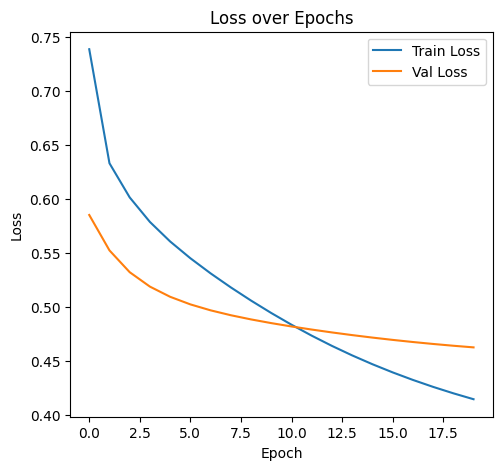

In [87]:
# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='Train Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

##  根据训练好的DSSM构建2个用户塔子模型

In [88]:
"""
这行代码的含义是：
用训练好的 model 中的某些中间层（在这里是用户输入和用户 DNN 向量输出）来创建一个新的子模型；
inputs=model.user_input：指定新的子模型接收哪些输入（即用户特征）；
outputs=model.user_embedding：指定新的子模型输出什么（即用户 DNN 向量）；
相当于：构建一个从用户原始输入 → 用户 embedding 向量 的模型，用于推理。
同理：
item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)
构建一个从物品原始输入 → 物品 embedding 向量的模型。
"""

'\n这行代码的含义是：\n用训练好的 model 中的某些中间层（在这里是用户输入和用户 DNN 向量输出）来创建一个新的子模型；\ninputs=model.user_input：指定新的子模型接收哪些输入（即用户特征）；\noutputs=model.user_embedding：指定新的子模型输出什么（即用户 DNN 向量）；\n相当于：构建一个从用户原始输入 → 用户 embedding 向量 的模型，用于推理。\n同理：\nitem_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)\n构建一个从物品原始输入 → 物品 embedding 向量的模型。\n'

In [89]:
user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)

In [90]:
user_embedding_model

In [91]:
item_embedding_model

In [92]:
test_user_input

{'user_id': array([ 11,  36,  37,  74, 148, 159, 165, 172, 175, 182, 186]),
 'gender': array([2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 3], dtype=int64),
 'age': array([1, 1, 1, 6, 6, 1, 6, 1, 1, 3, 6], dtype=int64),
 'level': array([5, 2, 6, 4, 3, 4, 4, 5, 1, 1, 1], dtype=int64),
 'user_lang': array([ 7,  4,  4,  4,  4,  2, 15,  8,  2,  2,  5]),
 'country': array([14, 27, 24,  5, 11,  3,  5, 12,  3,  3,  6]),
 'platform': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'is_new': array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int64),
 'hist_sm_id': array([[ 63,  59,  97,  97,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,

In [93]:
test_item_input

{'sm_id': array([ 90,  85,  72, 103,  18,  30,  48,  66,  45,  26,  61]),
 'artist_gender': array([2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3], dtype=int64),
 'song_quality': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 'song_recording_count': array([61, 30, 94, 86, 73, 44, 86, 18, 24, 13, 15], dtype=int64),
 'song_genres': array([1, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8])}

### 用训练好的模型将用户和item的输入特征映射为一个低维向量（embedding）

In [94]:
user_embs = user_embedding_model.predict(test_user_input, batch_size=2 ** 12)
item_embs = item_embedding_model.predict(test_item_input, batch_size=2 ** 12)

In [95]:
user_embs

array([[ 1.81467589e-02, -3.40146432e-03,  1.77635327e-02,
        -1.29748434e-02, -2.38075224e-03, -1.96756935e-03,
        -6.35688100e-03,  5.87579142e-03,  7.81685300e-03,
        -8.88520479e-03, -9.03095212e-03, -5.23126870e-03,
         3.44711938e-03,  1.87475048e-02,  3.36031639e-03,
         3.21124564e-03, -4.98577021e-03,  1.81753642e-03,
        -1.55444182e-02, -5.82931447e-04, -3.15695931e-03,
        -6.04853826e-03,  1.21582067e-02,  9.46342479e-04,
        -2.40021152e-03, -2.25301040e-03, -4.43823170e-03,
        -1.89412781e-03,  2.47067946e-05,  9.31242667e-03,
        -4.91050445e-03,  1.32204406e-03],
       [ 1.12603037e-02, -2.00537406e-03,  1.30767487e-02,
        -8.25319905e-03, -1.48151640e-03, -8.55046150e-04,
        -5.03360108e-03,  4.17787209e-03,  5.50343562e-03,
        -5.69614442e-03, -7.14619644e-03, -2.22347304e-03,
         3.29911965e-03,  1.20388130e-02,  2.86507094e-03,
         3.33420397e-03, -2.09632772e-03,  1.97852636e-03,
        -9.76

In [96]:
test_user_input

{'user_id': array([ 11,  36,  37,  74, 148, 159, 165, 172, 175, 182, 186]),
 'gender': array([2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 3], dtype=int64),
 'age': array([1, 1, 1, 6, 6, 1, 6, 1, 1, 3, 6], dtype=int64),
 'level': array([5, 2, 6, 4, 3, 4, 4, 5, 1, 1, 1], dtype=int64),
 'user_lang': array([ 7,  4,  4,  4,  4,  2, 15,  8,  2,  2,  5]),
 'country': array([14, 27, 24,  5, 11,  3,  5, 12,  3,  3,  6]),
 'platform': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'is_new': array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int64),
 'hist_sm_id': array([[ 63,  59,  97,  97,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,

In [97]:
user_embs.shape

(11, 32)

In [98]:
item_embs

array([[-5.58385020e-03, -1.65546278e-03, -4.72899945e-03,
         1.27366150e-03,  2.12901132e-03, -6.31801318e-04,
        -1.16212934e-03, -4.79698321e-03, -4.38605109e-03,
         1.43689231e-03,  2.08538910e-03,  1.43495295e-03,
         2.78345356e-03, -4.63257078e-03,  5.77171275e-04,
        -3.78435152e-03,  2.15340010e-03,  3.15612438e-03,
         3.76143283e-03,  3.10022221e-03, -1.65524136e-04,
        -5.09411562e-04, -1.83603563e-03, -1.15262077e-03,
        -5.71695913e-04,  3.76041397e-03, -1.93025207e-03,
         4.37735859e-03,  7.50195934e-04,  4.02894244e-03,
         2.17869459e-03,  1.23926741e-03],
       [-5.71403513e-03, -1.47377094e-03, -4.35526762e-03,
         1.06183090e-03,  1.85837131e-03, -6.08144503e-04,
        -1.12084474e-03, -4.85828286e-03, -4.35242290e-03,
         1.59818435e-03,  1.75254885e-03,  1.36489328e-03,
         3.00079212e-03, -4.25808690e-03,  4.68484854e-04,
        -3.94844124e-03,  2.33992864e-03,  3.31134931e-03,
         3.60

In [99]:
item_embs.shape

(11, 32)

In [100]:
test_item_input

{'sm_id': array([ 90,  85,  72, 103,  18,  30,  48,  66,  45,  26,  61]),
 'artist_gender': array([2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3], dtype=int64),
 'song_quality': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 'song_recording_count': array([61, 30, 94, 86, 73, 44, 86, 18, 24, 13, 15], dtype=int64),
 'song_genres': array([1, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8])}

## Faiss 向量召回用户可能的items

In [101]:
# 1. Faiss 向量召回，先将test_item这些items存入到向量数据库
index = faiss.IndexFlatIP(item_embs.shape[1])
index.add(item_embs)

In [102]:
index

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x00000225E4333E10> >

In [103]:
# 2. 用每一个用户的 embedding 向量，去检索向量数据库中最相似的 top-k 个 item，返回它们的索引（I）和相似度（D）
"""
IndexFlatIP 表示使用 Inner Product（内积） 来衡量相似度，适用于你模型输出 embedding 已经过 normalize（或你使用的是点积打分）时。
D 是每个用户的 top-k 相似 item 的相似度分值（内积值）。
I 是这些 item 的索引（对应 item_embs 中的下标）。

很好，这段代码中的 D 是 用户向量与所有物品向量之间的内积相似度，确实是按相似度由高到低排列的，但不是概率，
而是内积分值（dot product）

内积分值越大，表示“相似度越高”，因此：

在很多推荐/检索场景中，内积值确实可以作为排序分数；

如果你的模型是用内积（dot product）作为打分函数训练的（比如 DSSM、DIN、Two-Tower 等），那这个内积本身就对应于一个“得分”，也可以理解为“越大越有可能被点击”；

但它不等于概率，只是一个未归一化的分值。
"""
D, I = index.search(user_embs, args.recall_topk)

In [104]:
D

array([[-2.35527186e-04, -4.23936814e-04, -4.33549460e-04],
       [-1.46204955e-04, -2.78617023e-04, -2.85716174e-04],
       [-1.35976530e-04, -2.55675055e-04, -2.62084999e-04],
       [-1.17459451e-04, -2.15453183e-04, -2.21264025e-04],
       [-1.29645938e-04, -2.39721965e-04, -2.45989941e-04],
       [-1.74347530e-04, -3.23708024e-04, -3.29145347e-04],
       [-1.18106575e-04, -2.15316541e-04, -2.21108668e-04],
       [-1.72771746e-04, -3.07414361e-04, -3.15200683e-04],
       [-1.10378242e-04, -3.08085117e-04, -3.12183751e-04],
       [-1.29759472e-04, -2.88341107e-04, -2.93260673e-04],
       [-9.31108443e-05, -2.20910937e-04, -2.26899021e-04]], dtype=float32)

In [105]:
D.shape  # 11行代码11个user_id,3代表每个每个user_id召回相似 item 的相似度分值（内积值）

(11, 3)

In [106]:
I

array([[2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4]], dtype=int64)

In [107]:
# 3. 构造真实标签，获取这些user_id实际点击过的的items

In [108]:
for item in test_set:
    print(item)

(11, [63, 59, 97, 97, 44], 90, 1, 5, 1)
(36, [85], 85, 1, 1, 1)
(37, [72], 72, 1, 1, 1)
(74, [103], 103, 1, 1, 1)
(148, [18], 18, 1, 1, 1)
(159, [30], 30, 1, 1, 1)
(165, [48], 48, 1, 1, 1)
(172, [66], 66, 1, 1, 1)
(175, [45, 98, 120, 91, 82], 45, 1, 5, 1)
(182, [26], 26, 1, 1, 1)
(186, [61], 61, 1, 1, 1)


In [109]:
test_true_label = {line[0]: [line[2]] for line in test_set}

In [110]:
test_true_label  # 额，我感觉这样是不是有问题啊，每个user_id对应的item只有一个？

{11: [90],
 36: [85],
 37: [72],
 74: [103],
 148: [18],
 159: [30],
 165: [48],
 172: [66],
 175: [45],
 182: [26],
 186: [61]}

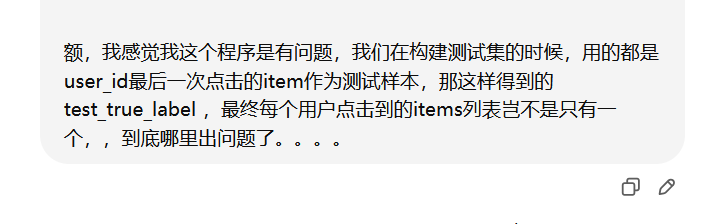

In [111]:
test_user_input

{'user_id': array([ 11,  36,  37,  74, 148, 159, 165, 172, 175, 182, 186]),
 'gender': array([2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 3], dtype=int64),
 'age': array([1, 1, 1, 6, 6, 1, 6, 1, 1, 3, 6], dtype=int64),
 'level': array([5, 2, 6, 4, 3, 4, 4, 5, 1, 1, 1], dtype=int64),
 'user_lang': array([ 7,  4,  4,  4,  4,  2, 15,  8,  2,  2,  5]),
 'country': array([14, 27, 24,  5, 11,  3,  5, 12,  3,  3,  6]),
 'platform': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'is_new': array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int64),
 'hist_sm_id': array([[ 63,  59,  97,  97,  44,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 85,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 72,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [ 18,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,

In [112]:
test_item_input['sm_id']

array([ 90,  85,  72, 103,  18,  30,  48,  66,  45,  26,  61])

In [113]:
I

array([[2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4],
       [2, 1, 4]], dtype=int64)

In [114]:
### 这里感觉有点问题啊。。。

In [115]:
# # 3. 计算 recall
recall_10, recall_50 = [], []
for i, uid in enumerate(test_user_input['user_id']):
    # print(i,uid)
    # print(item_ids['sm_id'])
    """
    这行代码的作用是：
    对于每个用户 i 的推荐物品索引 I[i]，将这些索引映射为物品的 ID（从 item_ids 中提取），形成最终的推荐列表 pred。

    举个例子，如果 I[i] = [2, 5, 8]，那么 pred 就是 [1003, 1006, 1009]，即推荐给用户 i 的物品 ID。

    希望这个解释清楚了！如果还有不明白的地方，随时告诉我。
    """
    # pred = [item_ids['sm_id'].values[x] for x in I[i]]
    pred = item_ids['sm_id'].iloc[I[i]].tolist()

    """
    recall_N 是一个计算 召回率 的函数。召回率的定义是：
    Recall=推荐结果中包含的实际点击物品数实际点击的物品总数
    Recall=实际点击的物品总数推荐结果中包含的实际点击物品数​

    具体来说，recall_N(test_true_label[uid], pred, N=10) 计算的是用户 uid 在推荐列表 pred 中的前 N=10 个物品中，实际点击物品 test_true_label[uid] 的 召回率。
    """
    rec_10 = recall_N(test_true_label[uid], pred, N=10)
    rec_50 = recall_N(test_true_label[uid], pred, N=50)
    recall_10.append(rec_10)
    recall_50.append(rec_50)

print("recall@10:", np.mean(recall_10))
print("recall@50:", np.mean(recall_50))

recall@10: 0.09090909090909091
recall@50: 0.09090909090909091


## 直接预估的方式

In [119]:
pass